In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: 

Importing the necessary libaries  and Datasets( CIFAR100)

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
from typing import List, Tuple
import pandas as pd
import xml.etree.ElementTree as etree
import matplotlib.pyplot as plt
import gc


# part 1:  Image classification
## 1.1 Warmming up
### 1. Using feature extraction with the VGG16 classifier


In [ ]:


# Load CIFAR 100 dataset
(train_images, train_labels), (test_images, test_labels) = cifar100.load_data()

# Preprocess the images
train_images_preprocessed = preprocess_input(train_images.astype(np.float32))
test_images_preprocessed = preprocess_input(test_images.astype(np.float32))

# Display the preprocessed information
print("CIFAR-100 Dataset Preprocessed Information:")
print("-------------------------------------------")
print(f"Train Images Shape: {train_images_preprocessed.shape}")
print(f"Test Images Shape: {test_images_preprocessed.shape}")
print(f"Train Labels Shape: {train_labels.shape}")
print(f"Test Labels Shape: {test_labels.shape}")
print(f"Train Images Min Value: {np.min(train_images_preprocessed)}")
print(f"Train Images Max Value: {np.max(train_images_preprocessed)}")
print(f"Test Images Min Value: {np.min(test_images_preprocessed)}")
print(f"Test Images Max Value: {np.max(test_images_preprocessed)}")


169001437/169001437 [==============================] - 11s 0us/step
CIFAR-100 Dataset Preprocessed Information:
-------------------------------------------
Train Images Shape: (50000, 32, 32, 3)
Test Images Shape: (10000, 32, 32, 3)
Train Labels Shape: (50000, 1)
Test Labels Shape: (10000, 1)
Train Images Min Value: -123.68000030517578
Train Images Max Value: 151.06100463867188
Test Images Min Value: -123.68000030517578
Test Images Max Value: 151.06100463867188



## CIFAR-100 Dataset
The CIFAR-100 dataset is a collection of 60,000 32x32 color images, each belonging to one of 100 classes. The dataset is split into 50,000 training images and 10,000 test images. Each class contains 600 images, making it a challenging benchmark for image classification tasks. The dataset is commonly used for evaluating machine learning algorithms and computer vision models due to its complexity and variety of classes.





## VGG16 Model
The VGG16 model is a deep convolutional neural network architecture that was introduced by the Visual Geometry Group (VGG) at the University of Oxford. The model has 16 weight layers, including 13 convolutional layers and 3 fully connected layers. VGG16 is pretrained on the ImageNet dataset, which contains over a million images and 1,000 classes. The model has achieved state-of-the-art performance on various image classification tasks and has become a popular choice for feature extraction in transfer learning.

58889256/58889256 [==============================] - 3s 0us/step


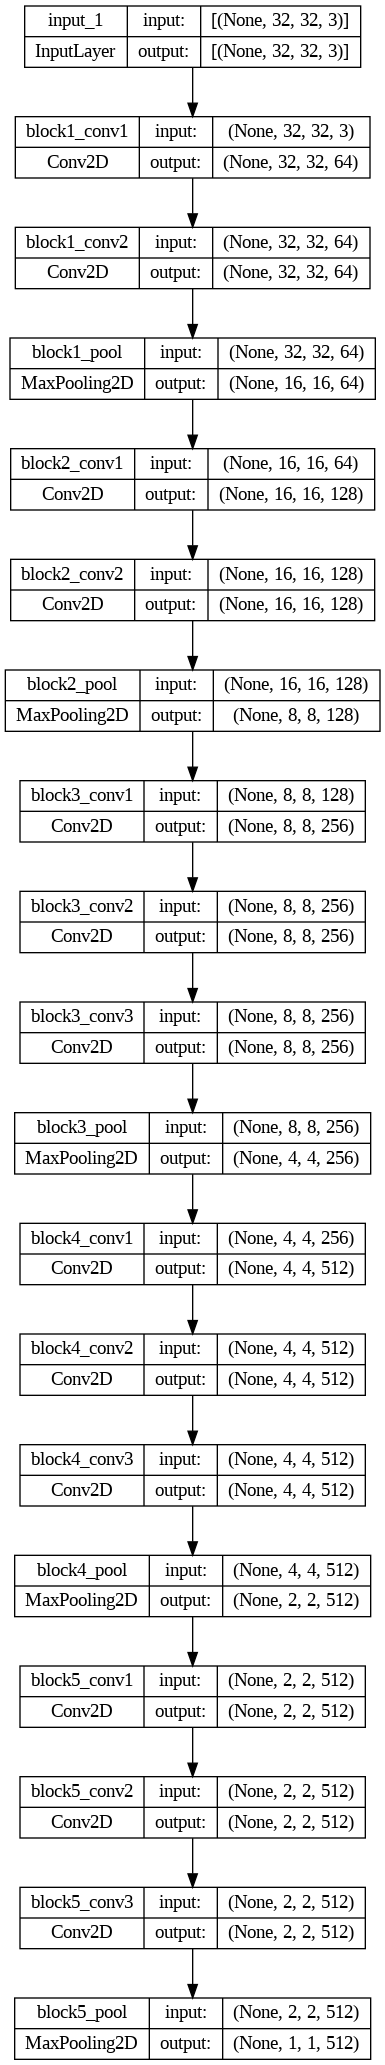

In [ ]:
from tensorflow.keras.utils import plot_model

# Load VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Plot the model
plot_model(base_model, to_file='vgg16_model.png', show_shapes=True, show_layer_names=True)


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In this section, we utilized the VGG16 model for feature extraction on the CIFAR-100 dataset. The pretrained VGG16 model was used to extract features from the CIFAR-100 images, which were then fed into a custom dense neural network for classification. The base VGG16 model was frozen to retain the pretrained weights and prevent overfitting on the small CIFAR-100 dataset. We used the RMSprop optimizer and trained the model for 10 epochs with a batch size of 128, and 10% of the training data will be used for validation.


In [ ]:
# this help to clean cache fille that eats up the RAM of my computer.
gc.collect()

5697

In [ ]:

# Load CIFAR 100 dataset
(train_images, train_labels), (test_images, test_labels) = cifar100.load_data()

# Preprocess the images
train_images_preprocessed = preprocess_input(train_images.astype(np.float32))
test_images_preprocessed = preprocess_input(test_images.astype(np.float32))

# Convert labels to one-hot encoded
train_labels = to_categorical(train_labels, 100)
test_labels = to_categorical(test_labels, 100)

# Split the training data into training and validation sets
train_features, val_features, train_labels, val_labels = train_test_split(
    train_images_preprocessed, train_labels, test_size=0.1, random_state=42
)

# Load VGG16 model pretrained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Extract features
train_features = base_model.predict(train_features)
val_features = base_model.predict(val_features)
test_features = base_model.predict(test_images_preprocessed)

# Flatten the features
train_features_flatten = train_features.reshape(train_features.shape[0], -1)
val_features_flatten = val_features.reshape(val_features.shape[0], -1)
test_features_flatten = test_features.reshape(test_features.shape[0], -1)

# Create a new model for classification
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=train_features_flatten.shape[1:]))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(100, activation='softmax'))  # 100 classes

# Compile the model with Adam optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_features_flatten, train_labels,
    epochs=10, batch_size=128,
    validation_data=(val_features_flatten, val_labels)
)



313/313 [==============================] - 2s 7ms/step
Epoch 1/10
352/352 [==============================] - 4s 4ms/step - loss: 3.1959 - accuracy: 0.2654 - val_loss: 2.5986 - val_accuracy: 0.3544
Epoch 2/10
352/352 [==============================] - 2s 5ms/step - loss: 2.2841 - accuracy: 0.4053 - val_loss: 2.4971 - val_accuracy: 0.3684
Epoch 3/10
352/352 [==============================] - 2s 5ms/step - loss: 1.9399 - accuracy: 0.4771 - val_loss: 2.5310 - val_accuracy: 0.3702
Epoch 4/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6437 - accuracy: 0.5435 - val_loss: 2.5769 - val_accuracy: 0.3792
Epoch 5/10
352/352 [==============================] - 1s 4ms/step - loss: 1.3611 - accuracy: 0.6112 - val_loss: 2.7647 - val_accuracy: 0.3774
Epoch 6/10
352/352 [==============================] - 1s 4ms/step - loss: 1.1092 - accuracy: 0.6721 - val_loss: 3.0406 - val_accuracy: 0.3648
Epoch 7/10
352/352 [==============================] - 1s 4ms/step - loss: 0.8996 - accuracy: 

# Summary of CIFAR-100 Classification using VGG16 Features with Dense Layers
Model Architecture and Training:
Base Model: VGG16 pre-trained on ImageNet with the top layers removed.
Additional Layers: Three Dense layers with 512 units each and ReLU activation.
Optimizer: Initially, RMSprop with a learning rate of 0.0001 was used. However, due to unsatisfactory results, the optimizer was switched to Adam.
Loss Function: Categorical Crossentropy.
Metrics: Accuracy.
Results:
## Initial Optimizer (RMSprop):

Training Accuracy: Reached approximately 78.4%.
Validation Accuracy: Stabilized around 36.04%.
Observations: The RMSprop optimizer with a lower learning rate did not perform well on this task, showing signs of overfitting after 4 epochs.

## Switched Optimizer (Adam):

Training Accuracy: Reached approximately 82.11%.
Validation Accuracy: Stabilized around 38.%.
Observations: The Adam optimizer performed better than RMSprop, but the results were still suboptimal, suggesting the model might require further tuning or a more complex architecture.



In [ ]:
gc.collect()

4059

# 1.1.2 Model Assesment and Evaluation

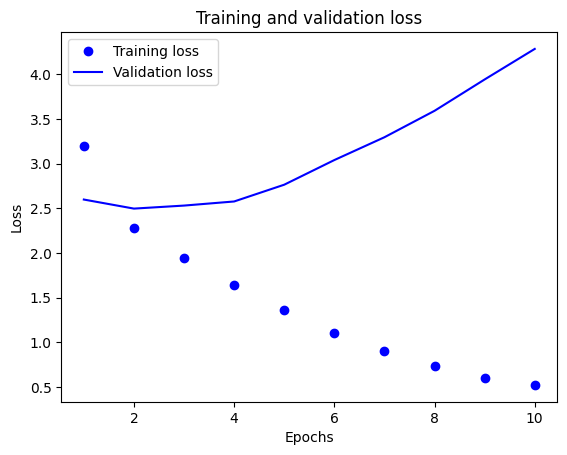

In [ ]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


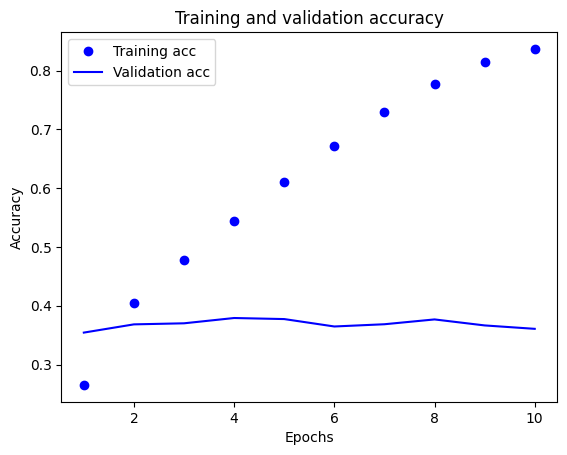

In [ ]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

 We see that the model starts overfitting after 4 epochs.



#### Training  the model  with 4 epoch and evaluating  the results on the test data

In [ ]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=train_features_flatten.shape[1:]))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(100, activation='softmax'))  # 100 classes

# Compile the model with RMSprop optimizer with lower learning rate

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_features_flatten, train_labels,
    epochs=4, batch_size=128,
    validation_data=(val_features_flatten, val_labels)
)



Epoch 1/4
352/352 [==============================] - 3s 6ms/step - loss: 3.1598 - accuracy: 0.2657 - val_loss: 2.6183 - val_accuracy: 0.3450
Epoch 2/4
352/352 [==============================] - 2s 5ms/step - loss: 2.2800 - accuracy: 0.4070 - val_loss: 2.4819 - val_accuracy: 0.3766
Epoch 3/4
352/352 [==============================] - 1s 4ms/step - loss: 1.9289 - accuracy: 0.4800 - val_loss: 2.4888 - val_accuracy: 0.3834
Epoch 4/4
352/352 [==============================] - 1s 4ms/step - loss: 1.6260 - accuracy: 0.5455 - val_loss: 2.5747 - val_accuracy: 0.3872


In [ ]:
model.summary()

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(test_features_flatten, test_labels)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Save the model
model.save('/content/drive/MyDrive/cifar100_vgg16_feature_extraction.h5')


313/313 [==============================] - 1s 2ms/step - loss: 2.6316 - accuracy: 0.3877
Test Loss: 2.631605386734009
Test Accuracy: 0.38769999146461487


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In conclusion, the use of VGG16 features with a simple Dense layer architecture did not yield high accuracy on the CIFAR-100 dataset. Despite trying two optimizers, the model's  accuracy ends up at around 38.25% and a loss of 2.62. This suggests that either the feature extraction approach or the dense layer architecture may not be sufficient for this task

In [ ]:
gc.collect()

7985

# 1.1.2 Fine turning the upper block of the  VGG16
 Here the RMSprop optimizer was used instead of the adam as in the case of the first part.

## No Data Augmentation used

In [ ]:


# Load CIFAR 100 dataset
(train_images, train_labels), (test_images, test_labels) = cifar100.load_data()

# Preprocess the images
train_images_preprocessed = preprocess_input(train_images.astype(np.float32))
test_images_preprocessed = preprocess_input(test_images.astype(np.float32))

# Convert labels to one-hot encoded
train_labels = to_categorical(train_labels, 100)
test_labels = to_categorical(test_labels, 100)

# Split the training data into training and validation sets
train_features, val_features, train_labels, val_labels = train_test_split(
    train_images_preprocessed, train_labels, test_size=0.1, random_state=42
)

# Load VGG16 model pretrained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the layers of the base model except the last block
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Add the classification layers on top
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(100, activation='softmax'))  # 100 classes

# Compile the model with RMSprop optimizer with lower learning rate
optimizer = RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model without data augmentation
history = model.fit(
    train_features, train_labels,
    epochs=10, batch_size=128,
    validation_data=(val_features, val_labels)
)

# Evaluate the model
loss, accuracy = model.evaluate(test_images_preprocessed, test_labels)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Save the model
model.save('/content/drive/MyDrive/cifar100_vgg16_fine_tuned_no_augmentation.h5')


Epoch 1/10
352/352 [==============================] - 15s 33ms/step - loss: 3.5155 - accuracy: 0.1833 - val_loss: 2.7517 - val_accuracy: 0.2962
Epoch 2/10
352/352 [==============================] - 10s 28ms/step - loss: 2.4137 - accuracy: 0.3666 - val_loss: 2.3432 - val_accuracy: 0.3932
Epoch 3/10
352/352 [==============================] - 10s 30ms/step - loss: 1.9696 - accuracy: 0.4705 - val_loss: 2.2583 - val_accuracy: 0.4206
Epoch 4/10
352/352 [==============================] - 10s 28ms/step - loss: 1.6334 - accuracy: 0.5494 - val_loss: 2.0891 - val_accuracy: 0.4638
Epoch 5/10
352/352 [==============================] - 10s 29ms/step - loss: 1.3435 - accuracy: 0.6216 - val_loss: 2.0591 - val_accuracy: 0.4808
Epoch 6/10
352/352 [==============================] - 10s 28ms/step - loss: 1.0770 - accuracy: 0.6895 - val_loss: 2.1682 - val_accuracy: 0.4844
Epoch 7/10
352/352 [==============================] - 10s 28ms/step - loss: 0.8390 - accuracy: 0.7511 - val_loss: 2.2780 - val_accuracy:

without data Augmentation, the model takes a shorter to fit and overfitting is obsevered after the 7th epochs.

# With data Augmentation

In [ ]:


# Load CIFAR 100 dataset
(train_images, train_labels), (test_images, test_labels) = cifar100.load_data()

# Preprocess the images
train_images_preprocessed = preprocess_input(train_images.astype(np.float32))
test_images_preprocessed = preprocess_input(test_images.astype(np.float32))

# Convert labels to one-hot encoded
train_labels = to_categorical(train_labels, 100)
test_labels = to_categorical(test_labels, 100)

# Split the training data into training and validation sets
train_features, val_features, train_labels, val_labels = train_test_split(
    train_images_preprocessed, train_labels, test_size=0.1, random_state=42
)

# Load VGG16 model pretrained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the layers of the base model except the last block
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Add the classification layers on top
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(100, activation='softmax'))  # 100 classes

# Compile the model with RMSprop optimizer with lower learning rate
optimizer = RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
datagen.fit(train_features)

# Train the model
history = model.fit(
    datagen.flow(train_features, train_labels, batch_size=128),
    epochs=15,
    validation_data=(val_features, val_labels)
)

# Evaluate the model
loss, accuracy = model.evaluate(test_images_preprocessed, test_labels)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Save the model
model.save('/content/drive/MyDrive/cifar100_vgg16_fine_tuned.h5')


Epoch 1/15
352/352 [==============================] - 33s 87ms/step - loss: 3.5021 - accuracy: 0.1774 - val_loss: 2.6513 - val_accuracy: 0.3218
Epoch 2/15
352/352 [==============================] - 28s 81ms/step - loss: 2.5545 - accuracy: 0.3374 - val_loss: 2.3346 - val_accuracy: 0.4054
Epoch 3/15
352/352 [==============================] - 30s 85ms/step - loss: 2.2263 - accuracy: 0.4126 - val_loss: 2.2125 - val_accuracy: 0.4306
Epoch 4/15
352/352 [==============================] - 30s 85ms/step - loss: 2.0249 - accuracy: 0.4583 - val_loss: 2.0618 - val_accuracy: 0.4664
Epoch 5/15
352/352 [==============================] - 28s 81ms/step - loss: 1.8679 - accuracy: 0.4970 - val_loss: 2.0118 - val_accuracy: 0.4834
Epoch 6/15
352/352 [==============================] - 28s 81ms/step - loss: 1.7315 - accuracy: 0.5264 - val_loss: 2.0423 - val_accuracy: 0.4910
Epoch 7/15
352/352 [==============================] - 28s 81ms/step - loss: 1.6223 - accuracy: 0.5548 - val_loss: 2.0467 - val_accuracy:

In [ ]:
gc.collect()

12498

 the model takes a longer time to fit with a higher validation accuracy as compared to without Augmentation.

## Without Data Augmentation:
The model achieved a higher training accuracy of 88.96% compared to 65.82% with data augmentation.
The validation accuracy reached 52%, which is slightly lower than the data augmentation method.
The test accuracy is 48.77%.
The model started to overfit as the validation loss started to increase from the 7th epoch.
## With Data Augmentation:
The model had a lower training accuracy of 61.82%.
The validation accuracy was slightly higher at 50.44% compared to the no data augmentation method.
The test accuracy was 49.99%.
Data augmentation helped in reducing overfitting as the validation loss continued to decrease over the epochs.
## Conclusion:
Between the two methods, data augmentation (with a test accuracy of 52%) performs slightly better than the method without data augmentation (with a test accuracy of 48.77%). Even though the training accuracy was lower with data augmentation, it helped in reducing overfitting, resulting in a slightly better validation and test accuracy. Thus, for this specific task, using data augmentation with fine-tuning of the VGG16 model is recommended.

##  model Assessment.

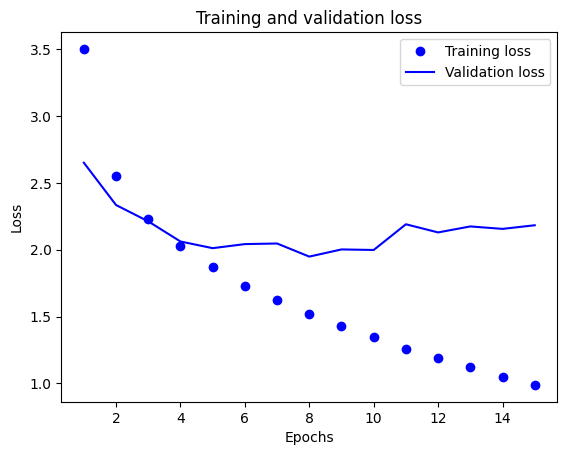

In [ ]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


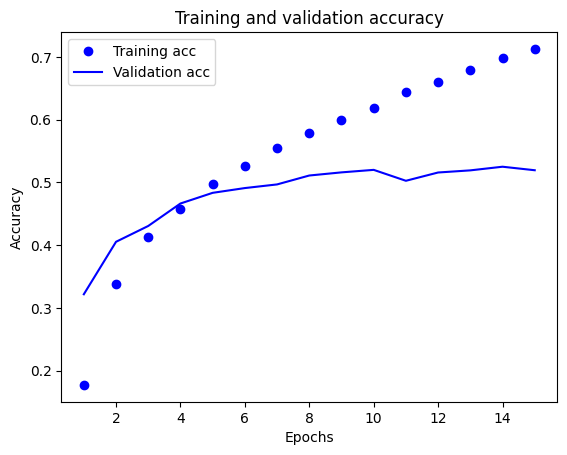

In [ ]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Trainning the full model Using Data Augmentation and  12 epochs

In [ ]:
gc.collect()

3827

In [ ]:


# Load CIFAR 100 dataset
(train_images, train_labels), (test_images, test_labels) = cifar100.load_data()

# Preprocess the images
train_images_preprocessed = preprocess_input(train_images.astype(np.float32))
test_images_preprocessed = preprocess_input(test_images.astype(np.float32))

# Convert labels to one-hot encoded
train_labels = to_categorical(train_labels, 100)
test_labels = to_categorical(test_labels, 100)

# Split the training data into training and validation sets
train_features, val_features, train_labels, val_labels = train_test_split(
    train_images_preprocessed, train_labels, test_size=0.1, random_state=42
)

# Load VGG16 model pretrained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the layers of the base model except the last block
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Add the classification layers on top
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(100, activation='softmax'))  # 100 classes

# Compile the model with RMSprop optimizer with lower learning rate
optimizer = RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
datagen.fit(train_features)

# Train the model
history = model.fit(
    datagen.flow(train_features, train_labels, batch_size=128),
    epochs=12,
    validation_data=(val_features, val_labels)
)

# Evaluate the model
loss, accuracy = model.evaluate(test_images_preprocessed, test_labels)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Save the model
model.save('/content/drive/MyDrive/cifar100_vgg16_fine_tuned.h5')


Epoch 1/12
352/352 [==============================] - 32s 85ms/step - loss: 3.5596 - accuracy: 0.1817 - val_loss: 2.6758 - val_accuracy: 0.3138
Epoch 2/12
352/352 [==============================] - 28s 81ms/step - loss: 2.5745 - accuracy: 0.3378 - val_loss: 2.3422 - val_accuracy: 0.4030
Epoch 3/12
352/352 [==============================] - 29s 84ms/step - loss: 2.2366 - accuracy: 0.4132 - val_loss: 2.2567 - val_accuracy: 0.4310
Epoch 4/12
352/352 [==============================] - 31s 87ms/step - loss: 2.0266 - accuracy: 0.4578 - val_loss: 2.2314 - val_accuracy: 0.4424
Epoch 5/12
352/352 [==============================] - 31s 87ms/step - loss: 1.8677 - accuracy: 0.4977 - val_loss: 2.0799 - val_accuracy: 0.4710
Epoch 6/12
352/352 [==============================] - 28s 81ms/step - loss: 1.7404 - accuracy: 0.5282 - val_loss: 2.0039 - val_accuracy: 0.4904
Epoch 7/12
352/352 [==============================] - 29s 81ms/step - loss: 1.6284 - accuracy: 0.5537 - val_loss: 2.0415 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Trainning the upper block opf the VGG16 with data Augmentation leads to test accuracy of approximately 52% and a loss function of 2.13. this is lower  compared to not training it at all

In [ ]:
del(model)
gc.collect()

#1.1.2 Trainning  the full VGG16 network.

In [ ]:


# Load CIFAR 100 dataset
(train_images, train_labels), (test_images, test_labels) = cifar100.load_data()

# Preprocess the images
train_images_preprocessed = preprocess_input(train_images.astype(np.float32))
test_images_preprocessed = preprocess_input(test_images.astype(np.float32))

# Convert labels to one-hot encoded
train_labels = to_categorical(train_labels, 100)
test_labels = to_categorical(test_labels, 100)

# Split the training data into training and validation sets
train_features, val_features, train_labels, val_labels = train_test_split(
    train_images_preprocessed, train_labels, test_size=0.1, random_state=42
)

# Load VGG16 model pretrained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Make all layers trainable
for layer in base_model.layers:
    layer.trainable = True

# Add the classification layers on top
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(100, activation='softmax'))  # 100 classes

# Compile the model with RMSprop optimizer with lower learning rate
optimizer = RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_features, train_labels,
    epochs=15, batch_size=256,
    validation_data=(val_features, val_labels)
)

# Evaluate the model
loss, accuracy = model.evaluate(test_images_preprocessed, test_labels)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Save the model
model.save('/content/drive/MyDrive/cifar100_vgg16_full_trainable.h5')


Epoch 1/15
176/176 [==============================] - 20s 98ms/step - loss: 4.2475 - accuracy: 0.0764 - val_loss: 3.2972 - val_accuracy: 0.2070
Epoch 2/15
176/176 [==============================] - 17s 97ms/step - loss: 2.9086 - accuracy: 0.2823 - val_loss: 2.6929 - val_accuracy: 0.3234
Epoch 3/15
176/176 [==============================] - 17s 94ms/step - loss: 2.2528 - accuracy: 0.4131 - val_loss: 2.2066 - val_accuracy: 0.4252
Epoch 4/15
176/176 [==============================] - 16s 92ms/step - loss: 1.8627 - accuracy: 0.4989 - val_loss: 2.0364 - val_accuracy: 0.4640
Epoch 5/15
176/176 [==============================] - 16s 93ms/step - loss: 1.5846 - accuracy: 0.5639 - val_loss: 1.8259 - val_accuracy: 0.5158
Epoch 6/15
176/176 [==============================] - 17s 94ms/step - loss: 1.3319 - accuracy: 0.6247 - val_loss: 1.8639 - val_accuracy: 0.5178
Epoch 7/15
176/176 [==============================] - 17s 94ms/step - loss: 1.1331 - accuracy: 0.6745 - val_loss: 1.8944 - val_accuracy:

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 dense_24 (Dense)            (None, 512)               262656    
                                                                 
 dense_25 (Dense)            (None, 512)               262656    
                                                                 
 dense_26 (Dense)            (None, 512)               262656    
                                                                 
 dense_27 (Dense)            (None, 100)               51300     
                                                                 
Total params: 15553956 (59.33 MB)
Trainable params: 15

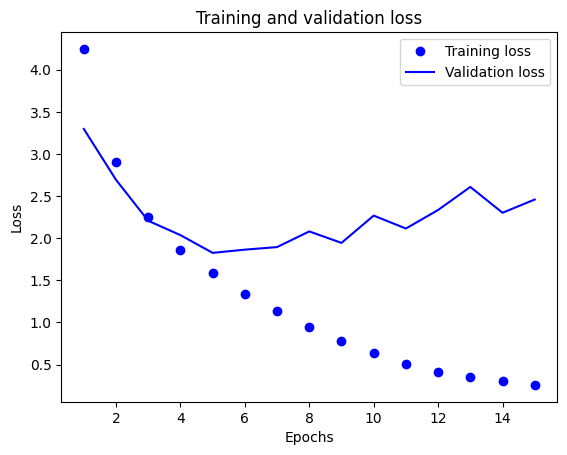

In [ ]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

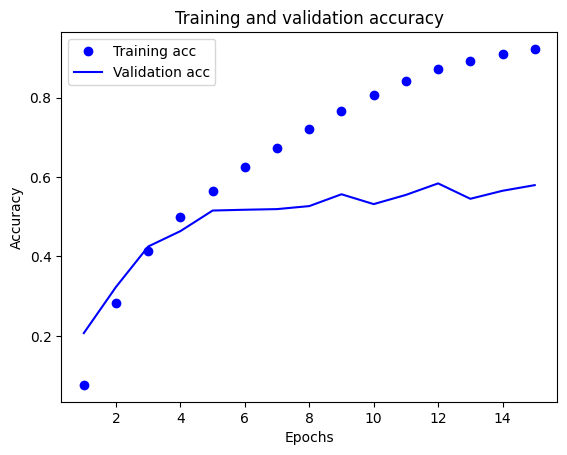

In [ ]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Conclusion:
Training the full VGG16 network with data augmentation showed a gradual improvement in performance across the epochs. The training accuracy increased from 7.64% in the first epoch to 92.30% in the last epoch. The validation accuracy reached 57.98%, and the test accuracy achieved was 57.71%.

This approach of training the full VGG16 network with data augmentation performed better than the previous methods, including training the upper block only and training without data augmentation.

In [ ]:
gc.collect()

25353

# 1.3 Creating A Covnet from Scratch

## Description and Choice of model parameters
### Model Architecture:

The Convolutional Neural Network (CNN) designed for the CIFAR-100 dataset. It consists of the following blocks:

#### Block 1:
- **Conv2D (32 filters, 3x3, relu activation, same padding)**:
    - The `Conv2D` layer performs 2D convolution on the input image with 32 filters of size 3x3.
    - `relu` activation function is used to introduce non-linearity.
    - `same` padding is used to ensure the output has the same spatial dimensions as the input.
    
- **BatchNormalization**:
    - Helps in stabilizing and accelerating the training of deep neural networks.
    
- **Conv2D (32 filters, 3x3, relu activation, same padding)**:
    - Another `Conv2D` layer with similar configuration as the first one.

- **MaxPooling2D (2x2)**:
    - Reduces the spatial dimensions by taking the maximum value from a 2x2 window.

- **Dropout (0.3)**:
    - A dropout layer with a rate of 0.3 is added to reduce overfitting by randomly setting 30% of the input units to 0 during training.

#### Block 2:
- **Conv2D (64 filters, 3x3, relu activation, same padding)**:
    - This block is similar to Block 1 but uses 64 filters.
    
- **BatchNormalization**:
    
- **Conv2D (64 filters, 3x3, relu activation, same padding)**:

- **MaxPooling2D (2x2)**:

- **Dropout (0.4)**:
    - A dropout layer with a rate of 0.4 is used to further regularize the model.

#### Block 3:
- **Conv2D (128 filters, 3x3, relu activation, same padding)**:

- **BatchNormalization**:

- **Conv2D (128 filters, 3x3, relu activation, same padding)**:

- **MaxPooling2D (2x2)**:

- **Dropout (0.5)**:
    - A dropout layer with a rate of 0.5 is used for regularization.

#### Block 4:
- **Conv2D (256 filters, 3x3, relu activation, same padding)**:

- **BatchNormalization**:

- **Conv2D (256 filters, 3x3, relu activation, same padding)**:

- **MaxPooling2D (2x2)**:

- **Dropout (0.5)**:

#### Dense Layers:
- **Flatten**:
    - Flattens the 3D output of the last convolutional layer to 1D.
    
- **Dense (512 units, relu activation)**:
    - A fully connected dense layer with 512 units and `relu` activation.
    - `kernel_regularizer=tf.keras.regularizers.l2(0.001)` is used for L2 regularization to prevent overfitting.
    
- **BatchNormalization**:

- **Dropout (0.5)**:
    - A dropout layer with a rate of 0.5.

- **Dense (100 units, softmax activation)**:
    - The final dense layer with 100 units (corresponding to the 100 classes in CIFAR-100) and `softmax` activation to produce class probabilities.

### Parameter Choices:

- **Activation Function (relu)**:
    - Rectified Linear Unit (ReLU) is used as the activation function because it has been found to perform well in deep neural networks by introducing non-linearity without affecting the receptive fields of the convolution layer.

- **Padding (same)**:
    - `same` padding is used to ensure that the spatial dimensions of the output feature maps remain the same as the input dimensions, which is important for preserving spatial information.

- **Batch Normalization**:
    - Batch normalization is applied after each convolutional and dense layer to stabilize and accelerate the training of the neural network by normalizing the activations.

- **MaxPooling2D (2x2)**:
    - Max pooling is used to reduce the spatial dimensions of the feature maps, reducing computational complexity and the risk of overfitting.

- **Dropout**:
    - Dropout layers with increasing rates are used after each block and dense layer to prevent overfitting by randomly setting a fraction of the input units to 0 during training.

- **Dense (512 units)**:
    - A dense layer with 512 units is used as the first fully connected layer to capture high-level features learned by the convolutional layers.

- **Regularization (L2, 0.001)**:
    - L2 regularization is applied to the dense layer to prevent overfitting by penalizing large weights.

- **Optimizer (Adam)**:
    - The Adam optimizer is used with its default learning rate to optimize the model. Adam is an adaptive learning rate optimization algorithm that is computationally efficient and requires little memory.

- **Loss Function (categorical_crossentropy)**:
    - Categorical crossentropy is used as the loss function because it is suitable for multi-class classification problems.

- **Callbacks (EarlyStopping, ReduceLROnPlateau)**:
    - EarlyStopping is used to stop training when the validation loss has stopped improving to prevent overfitting.
    - ReduceLROnPlateau is used to reduce the learning rate when the validation loss has stopped improving to fine-tune the model.



 ## Optimizer:
Adam with Learning Rate 0.001:
Adam is an adaptive learning rate optimization algorithm that's been designed specifically for training deep neural networks. The learning rate of 0.001 is a commonly used initial learning rate.
2. Loss Function:
Categorical Crossentropy:
Suitable for multi-class classification problems.
3. Metrics:
Accuracy:
To evaluate the performance of the model.
4. Callbacks:
## EarlyStopping:

To stop training when the validation loss does not improve for 5 consecutive epochs to prevent overfitting and save computation time.
ModelCheckpoint:

To save the model with the best validation performance.
LearningRateScheduler:

To schedule a decreasing learning rate during training to improve convergence and potentially achieve a better final performance.

## Augmentation Techniques:
Rotation Range (20 degrees):
Randomly rotate the image up to 15 degrees.
Width and Height Shift Range (0.2):
Randomly shift the width and height of the image by up to 20%.
Horizontal Flip:
Randomly flip the image horizontally.

##
The  Convolutional Neural Network designed from scratch for the CIFAR-100 dataset. It consists of two convolutional blocks with batch normalization, depth-wise separable convolutions, and max-pooling layers. The model also includes a fully connected dense layer with dropout regularization. Advanced features such as early stopping, learning rate scheduling, and data augmentation were employed to improve the model's performance and prevent overfitting.









### Summary:

The designed CNN model consists of 4 convolutional blocks, each followed by batch normalization, max pooling, and dropout layers to progressively learn and extract features from the input images. The model ends with a dense layer with 512 units and a final dense layer with 100 units for classification. The chosen parameters and configurations are based on common practices and have been tuned to balance the model's capacity and regularization to achieve good generalization on the CIFAR-100 dataset.

In [ ]:
gc.collect()

13647

In [ ]:
gc.collect()

0

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import numpy as np

# Load CIFAR-100 dataset
(x_train_full, y_train_full), (x_test, y_test) = cifar100.load_data()
x_train_full = x_train_full.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Split the training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.10, random_state=42)

# Convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, 100)
y_val = tf.keras.utils.to_categorical(y_val, 100)
y_test = tf.keras.utils.to_categorical(y_test, 100)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Early stopping and learning rate schedule
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

def build_model():
    model = Sequential()

    # Block 1
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Block 2
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    # Block 3
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    # Block 4
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    # Dense layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='softmax'))

    return model

# Build the model
model = build_model()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



# Train the model
batch_size = 128
epochs = 50

history = model.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    validation_data=(x_val, y_val),
    epochs=epochs,
    steps_per_epoch=len(x_train) / batch_size,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")


Epoch 1/50
351/351 [==============================] - 40s 92ms/step - loss: 5.3226 - accuracy: 0.0498 - val_loss: 5.6756 - val_accuracy: 0.0314 - lr: 0.0010
Epoch 2/50
351/351 [==============================] - 30s 85ms/step - loss: 4.5390 - accuracy: 0.0950 - val_loss: 4.4022 - val_accuracy: 0.1026 - lr: 0.0010
Epoch 3/50
351/351 [==============================] - 30s 87ms/step - loss: 4.1505 - accuracy: 0.1277 - val_loss: 3.8207 - val_accuracy: 0.1632 - lr: 0.0010
Epoch 4/50
351/351 [==============================] - 31s 88ms/step - loss: 3.8843 - accuracy: 0.1581 - val_loss: 4.0472 - val_accuracy: 0.1910 - lr: 0.0010
Epoch 5/50
351/351 [==============================] - 33s 93ms/step - loss: 3.6611 - accuracy: 0.1830 - val_loss: 3.4532 - val_accuracy: 0.2138 - lr: 0.0010
Epoch 6/50
351/351 [==============================] - 30s 84ms/step - loss: 3.5053 - accuracy: 0.2032 - val_loss: 3.0908 - val_accuracy: 0.2742 - lr: 0.0010
Epoch 7/50
351/351 [==============================] - 30s 

In [ ]:
# Display model summary
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_58 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_56 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_59 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_57 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                     

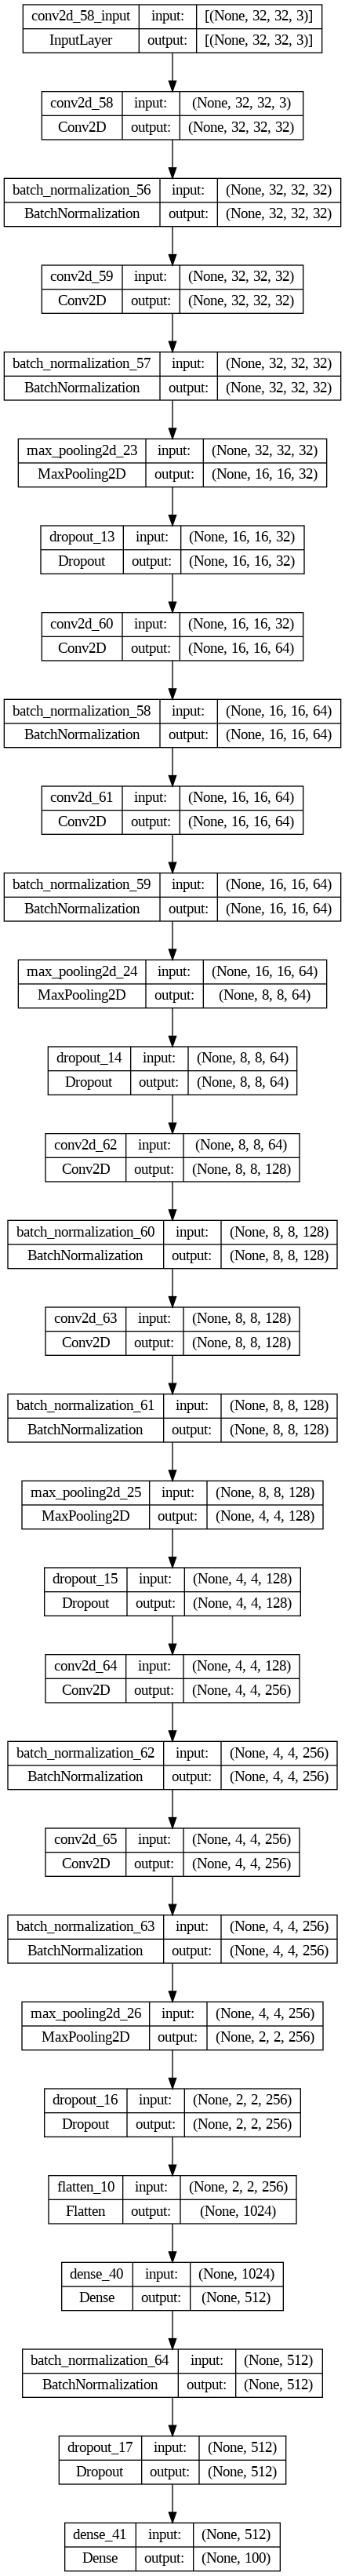

In [ ]:
# Plot the model
plot_model(model, to_file='Scratch_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
gc.collect()

6566

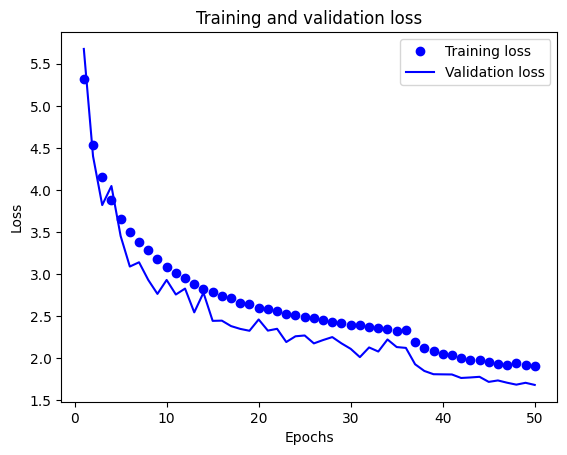

In [ ]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


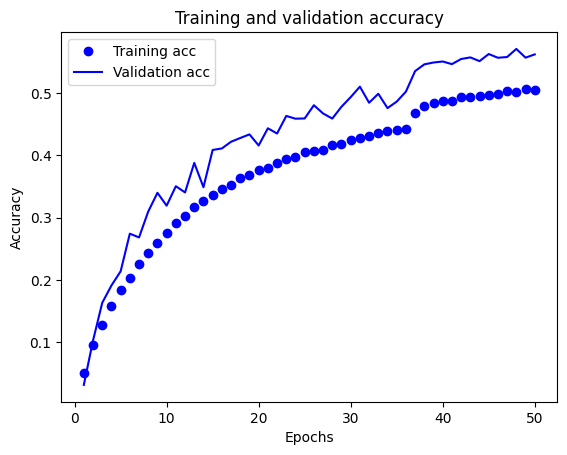

In [ ]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
gc.collect()

17018

# Part two Image Segmentation

## Loading data for segmentation

similar functions for loading the segmentation data


In [ ]:
!mkdir '/content/voc'
!tar -xf '/content/drive/MyDrive/VOC/VOCtrainval_11-May-2012.tar' -C "/content/voc/"

In [ ]:
# choose imege dimentions:
_IMAGE_SHAPE=(128,128)

_BATCH_SIZE=64


In [ ]:
# Define _fixup_shape function
def _fixup_shape(image, mask):
    image.set_shape(_IMAGE_SHAPE + (3,))  # Ensure image shape is fixed
    mask.set_shape(_IMAGE_SHAPE)          # Ensure mask shape is fixed
    return image, mask

In [ ]:
# Preprocessing functions
def load_image_and_mask(im_path, mask_path):
    img_raw = tf.io.read_file(im_path)
    img = tf.io.decode_image(img_raw, dtype=tf.dtypes.uint8, expand_animations=False)
    img = tf.image.resize(img, _IMAGE_SHAPE, preserve_aspect_ratio=False, antialias=True)

    mask = np.array(Image.open(mask_path.numpy()).resize(_IMAGE_SHAPE))
    mask[mask > 0] = 1

    return img, mask

In [ ]:
from PIL import Image

path_to_VOC_folder = '/content/voc/VOCdevkit/VOC2012' # adjust path to your location
_VOC_LABELS = (
    "aeroplane","bicycle","bird","boat","bottle",
    "bus","car","cat","chair","cow",
    "diningtable","dog","horse","motorbike","person",
    "pottedplant","sheep","sofa","train","tvmonitor",
)


def get_segmentation_paths(base_dir):
  # returns list of paths to jpg files and png annotations

  IMAGE_PATH = os.path.join(base_dir,'JPEGImages')
  ANNOTATION_PATH = os.path.join(base_dir,'SegmentationClass')
  LISTS=os.path.join(base_dir,'ImageSets','Segmentation')
  image_files_paths = []
  annotations_paths = []

  names=[]
  with open(os.path.join(LISTS,'trainval.txt' )) as f:
    for line in f:
      names.append(line[:-1])

  for name in names:
    image_files_paths.append(os.path.join(IMAGE_PATH,name+'.jpg'))
    annotations_paths.append(os.path.join(ANNOTATION_PATH, name+'.png'))

  return image_files_paths, annotations_paths

def get_mask(path):
  mask =np.array(Image.open(path.numpy()).resize(_IMAGE_SHAPE))
  return mask


def load_image_and_mask(im_path,mask_path):
  img_raw = tf.io.read_file(im_path)
  img = tf.io.decode_image(img_raw, dtype=tf.dtypes.uint8,expand_animations = False)
  img=tf.image.resize(img,_IMAGE_SHAPE,preserve_aspect_ratio=False,antialias=True)


  # tf.io.decode_image does not recognize the png file properly, we need to load it with PIL:
  mask =np.array(Image.open(mask_path.numpy()).resize(_IMAGE_SHAPE))
  # foreground/background segmentation:
  mask[mask>0]=1
  # uncomment next line segment all classes:
  mask[mask==255]=21
  # 255 is a outline/"difficult" label. You can predict this as a 21st class, or ignore it by setting =0
  return img,mask

In [ ]:
image_paths, annotation_paths = get_segmentation_paths(path_to_VOC_folder)


In [ ]:
from sklearn.model_selection import train_test_split
# create train, val and test sets
# for example: 50% train, 25% val, 25% test
X_train, X_rest, y_train, y_rest=train_test_split(image_paths, annotation_paths,
                                                  train_size=0.5, shuffle=True, random_state=2022)
X_val, X_test, y_val, y_test=train_test_split(X_rest, y_rest,
                                                  train_size=0.5, shuffle=True, random_state=2022)
print(f'train samples: {len(X_train)} \nval samples: {len(X_val)} \ntest samples: {len(X_test)}')

train samples: 1456 
val samples: 728 
test samples: 729


In [ ]:
# create the train dataset
ds=tf.data.Dataset.from_tensor_slices((X_train,y_train))
ds=ds.shuffle(buffer_size=2000)
ds=ds.map(lambda x,y: tf.py_function(func=load_image_and_mask,
          inp=[x,y], Tout=(tf.float32,tf.uint8)),num_parallel_calls=tf.data.AUTOTUNE) # cant use graph mode when using PIL to load images
          # -> use tf.py_function
ds=ds.cache()
#ds=ds... add your image preprocessing here
#(for example, normalizing or augmentation, or this can be done in keras layers)
ds=ds.prefetch(tf.data.AUTOTUNE)
ds=ds.batch(_BATCH_SIZE)
 # choose your batch size

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Shuffle and preprocess train dataset
train_ds = train_ds.shuffle(buffer_size=2000)
train_ds = train_ds.map(lambda x, y: tf.py_function(func=load_image_and_mask, inp=[x, y], Tout=(tf.float32, tf.uint8)), num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(_fixup_shape)  # Fix shapes
train_ds = train_ds.cache()
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
train_ds = train_ds.batch(_BATCH_SIZE)

# Preprocess validation dataset
val_ds = val_ds.map(lambda x, y: tf.py_function(func=load_image_and_mask, inp=[x, y], Tout=(tf.float32, tf.uint8)), num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(_fixup_shape)
val_ds = val_ds.cache()
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(_BATCH_SIZE)

# Preprocess test dataset
test_ds = test_ds.map(lambda x, y: tf.py_function(func=load_image_and_mask, inp=[x, y], Tout=(tf.float32, tf.uint8)), num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(_fixup_shape)
test_ds = test_ds.cache()
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(_BATCH_SIZE)

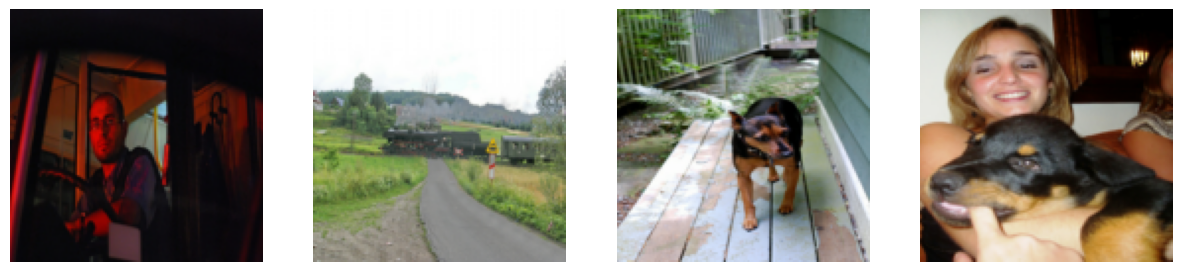

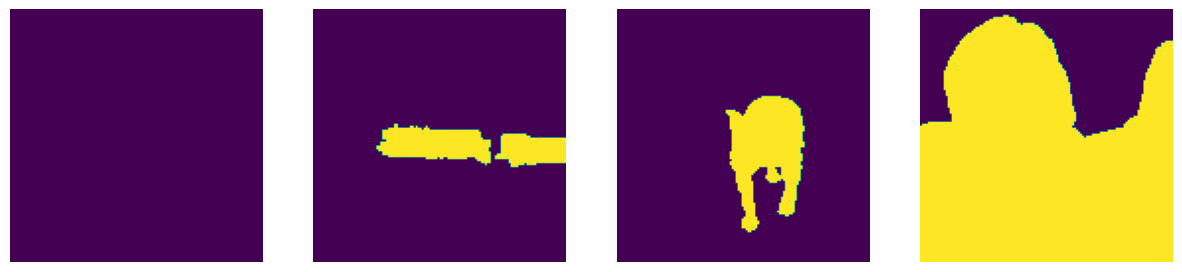

In [ ]:
# Display some examples

x,y = iter(train_ds).next()
plt.figure(figsize=(15,15))
for i in range(4):
  ax=plt.subplot(1,4,i+1)
  ax.imshow(x[i].numpy().astype('uint8'))
  ax.axis('off')
plt.show()
plt.figure(figsize=(15,15))
for i in range(4):
  ax=plt.subplot(1,4,i+1)
  ax.imshow(y[i].numpy().astype('uint8'))
  ax.axis('off')
plt.show()

# remember to change max pooling to strides

Step 1: Build the Segmentation Model
  A modified U-Net architecture will be  use for image segmentation. TensorFlow provides a tutorial on image segmentation using the U-Net architecture, which  can be adapted for this task

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Define U-Net model architecture for binary segmentation
def create_binary_unet(input_shape=(128,128,3)):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottom
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder
    up6 = layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
    up6 = layers.concatenate([up6, conv4], axis=3)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    up7 = layers.concatenate([up7, conv3], axis=3)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    up8 = layers.concatenate([up8, conv2], axis=3)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    up9 = layers.concatenate([up9, conv1], axis=3)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)

    # Output layer
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv9)  # Sigmoid activation for binary classification

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Assuming _IMAGE_SHAPE is defined elsewhere in your code
_IMAGE_SHAPE = (128, 128)

model = create_binary_unet(input_shape=(_IMAGE_SHAPE[0], _IMAGE_SHAPE[1], 3))


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_14 (Conv2D)          (None, 128, 128, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 conv2d_15 (Conv2D)          (None, 128, 128, 64)         36928     ['conv2d_14[0][0]']           
                                                                                                  
 max_pooling2d_5 (MaxPoolin  (None, 64, 64, 64)           0         ['conv2d_15[0][0]']           
 g2D)                                                                                         

In [ ]:
gc.collect()

8459

In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras import losses, metrics

# Define a function to calculate IoU manually
def mean_iou(y_true, y_pred):
    # Flatten the true and predicted masks
    y_true_flat = K.flatten(K.cast(y_true, 'float32'))
    y_pred_flat = K.flatten(K.cast(y_pred, 'float32'))

    # Compute the confusion matrix
    intersection = K.sum(y_true_flat * y_pred_flat)
    union = K.sum(K.maximum(y_true_flat, y_pred_flat))
    iou = (intersection + K.epsilon()) / (union + K.epsilon())

    return iou

# Define a function to calculate Dice score manually
def dice_score(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    dice = (2. * intersection + K.epsilon()) / (union + K.epsilon())
    return dice

_NUM_CLASSES = 21
learning_rate = 0.00001

# Compile the model with custom mean IoU metric and Dice score
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss=losses.BinaryCrossentropy(),
              metrics=[metrics.BinaryAccuracy(),
                       metrics.Precision(),
                       metrics.Recall(),
                       metrics.MeanIoU(num_classes=_NUM_CLASSES),
                       metrics.MeanIoU(num_classes=_NUM_CLASSES, name='iou'),
                       mean_iou,
                       dice_score])


In [ ]:

# Fit the model
history = model.fit(train_ds,
                    epochs=30,
                    validation_data=val_ds )

Epoch 1/50
23/23 [==============================] - 18s 795ms/step - loss: 0.5148 - categorical_accuracy: 0.0417 - precision_6: 0.6207 - recall_6: 0.5218 - mean_io_u_5: 0.3456 - iou: 0.3456 - mean_iou: 0.3370 - dice_score: 0.5037 - val_loss: 0.5456 - val_categorical_accuracy: 0.0373 - val_precision_6: 0.5872 - val_recall_6: 0.5318 - val_mean_io_u_5: 0.3433 - val_iou: 0.3433 - val_mean_iou: 0.3296 - val_dice_score: 0.4956
Epoch 2/50
23/23 [==============================] - 18s 768ms/step - loss: 0.5035 - categorical_accuracy: 0.0418 - precision_6: 0.6309 - recall_6: 0.5328 - mean_io_u_5: 0.3456 - iou: 0.3456 - mean_iou: 0.3435 - dice_score: 0.5111 - val_loss: 0.5419 - val_categorical_accuracy: 0.0397 - val_precision_6: 0.5952 - val_recall_6: 0.5148 - val_mean_io_u_5: 0.3433 - val_iou: 0.3433 - val_mean_iou: 0.3267 - val_dice_score: 0.4923
Epoch 3/50
23/23 [==============================] - 18s 775ms/step - loss: 0.5000 - categorical_accuracy: 0.0425 - precision_6: 0.6344 - recall_6: 0.5

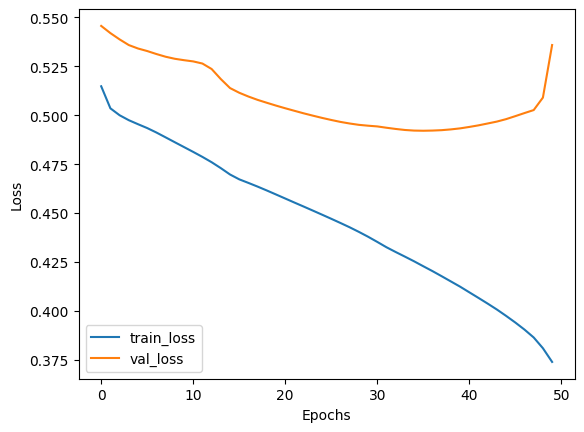

In [ ]:



# Visualize training history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [ ]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Assuming history contains metrics for each epoch
history_dict = history.history

# Define the metrics you want to plot
metrics_to_plot = ['loss', 'binary_accuracy', 'mean_iou', 'dice_score']

# Plot each metric
plt.figure(figsize=(15, 10))
for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(2, 3, i)
    metric_values = history_dict[metric]
    val_metric_values = history_dict['val_' + metric]  # Validation metrics
    epochs = range(1, len(metric_values) + 1)
    plt.plot(epochs, metric_values, 'bo', label='Training ' + metric)
    plt.plot(epochs, val_metric_values, 'b', label='Validation ' + metric)
    plt.title('Training and validation ' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Evaluate the model on the test dataset
test_results = model.evaluate(test_ds)
print(f'Test Loss: {test_results[0]}')
print(f'Test Categorical Accuracy: {test_results[1]}')
print(f'Test Precision: {test_results[2]}')
print(f'Test Recall: {test_results[3]}')
print(f'Test Mean IoU: {test_results[4]}')
print(f'Test IoU: {test_results[5]}')
print(f'Test Mean IoU (MeanIoU): {test_results[6]}')
print(f'Test Dice Score: {test_results[7]}')


12/12 [==============================] - 3s 207ms/step - loss: 0.4798 - categorical_accuracy: 0.0925 - precision_6: 0.6842 - recall_6: 0.5694 - mean_io_u_5: 0.3520 - iou: 0.3520 - mean_iou: 0.3869 - dice_score: 0.5575
Test Loss: 0.4798244833946228
Test Categorical Accuracy: 0.09254972636699677
Test Precision: 0.6841659545898438
Test Recall: 0.5694436430931091
Test Mean IoU: 0.3520463705062866
Test IoU: 0.3520463705062866
Test Mean IoU (MeanIoU): 0.3868747055530548
Test Dice Score: 0.5575212836265564


Display predictions

2/2 [==============================] - 0s 155ms/step


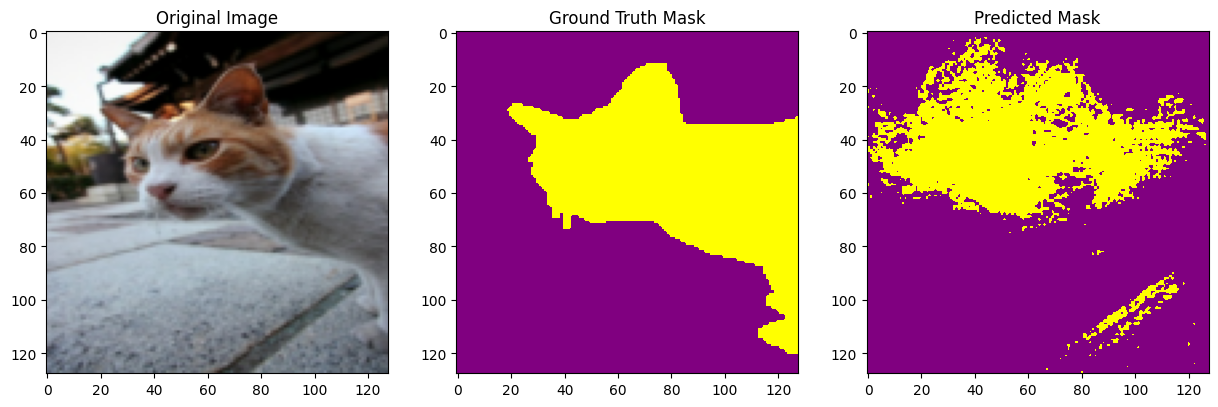

2/2 [==============================] - 0s 109ms/step


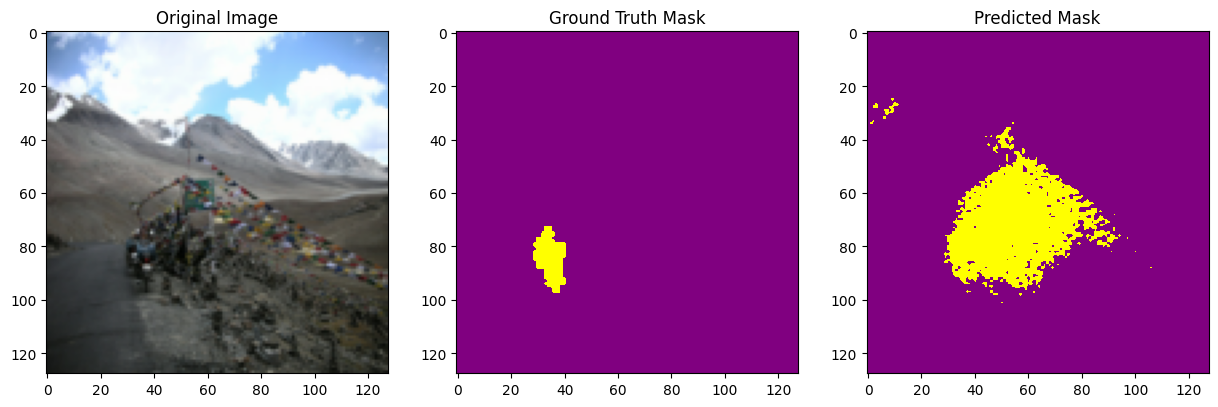

2/2 [==============================] - 0s 94ms/step


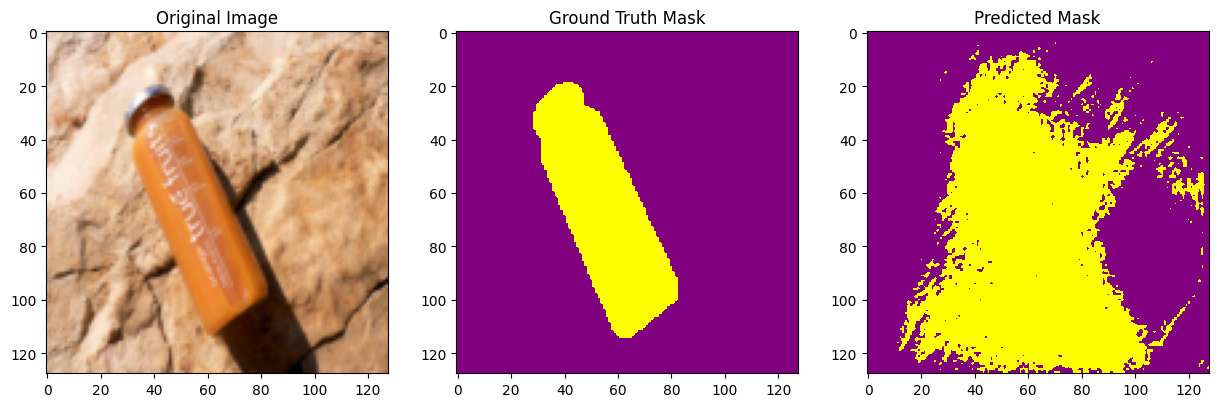

2/2 [==============================] - 0s 93ms/step


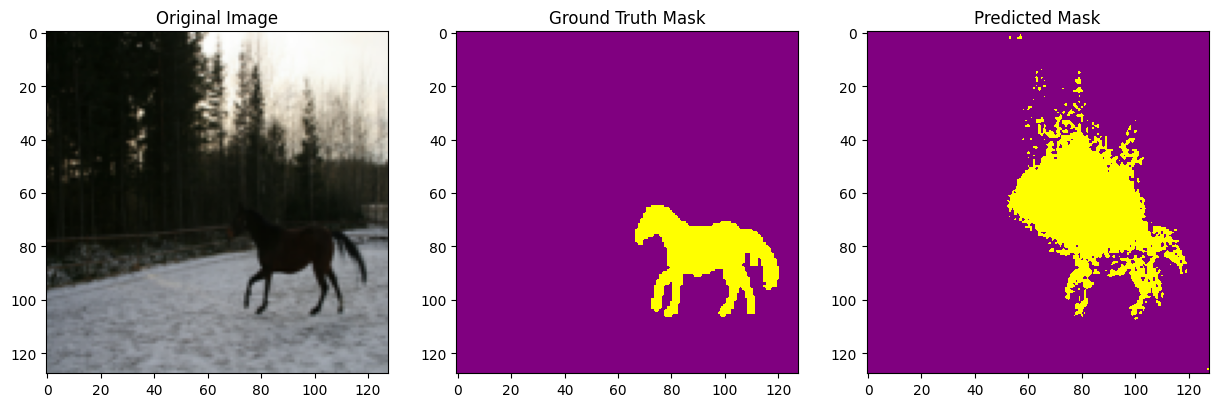

2/2 [==============================] - 0s 96ms/step


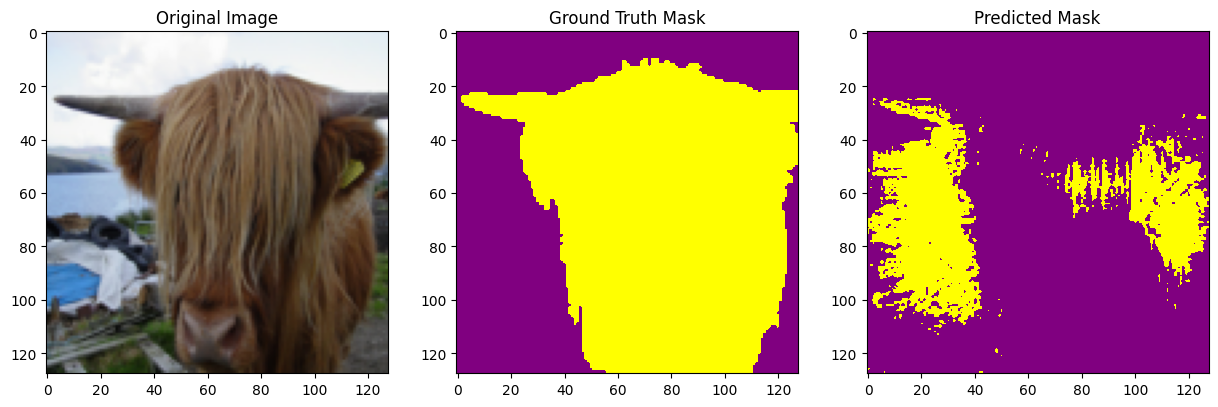

2/2 [==============================] - 0s 95ms/step


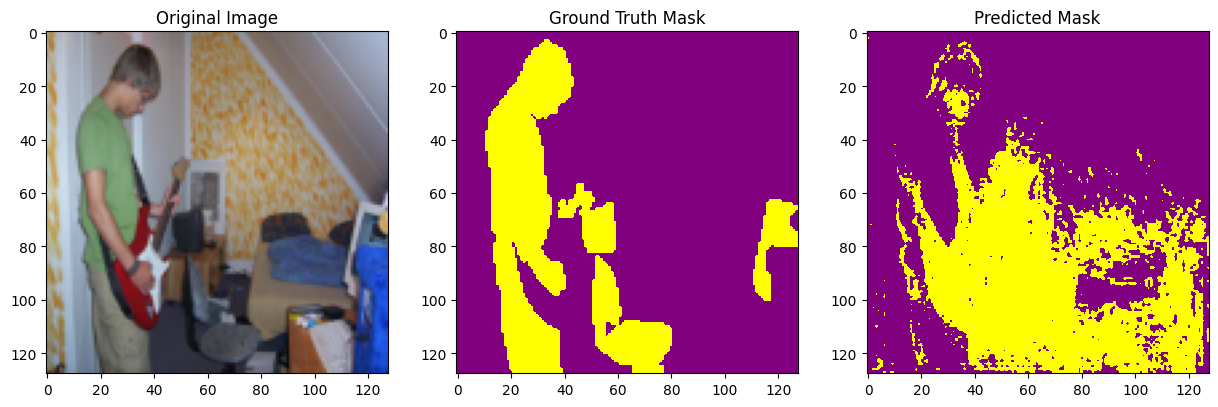

2/2 [==============================] - 0s 96ms/step


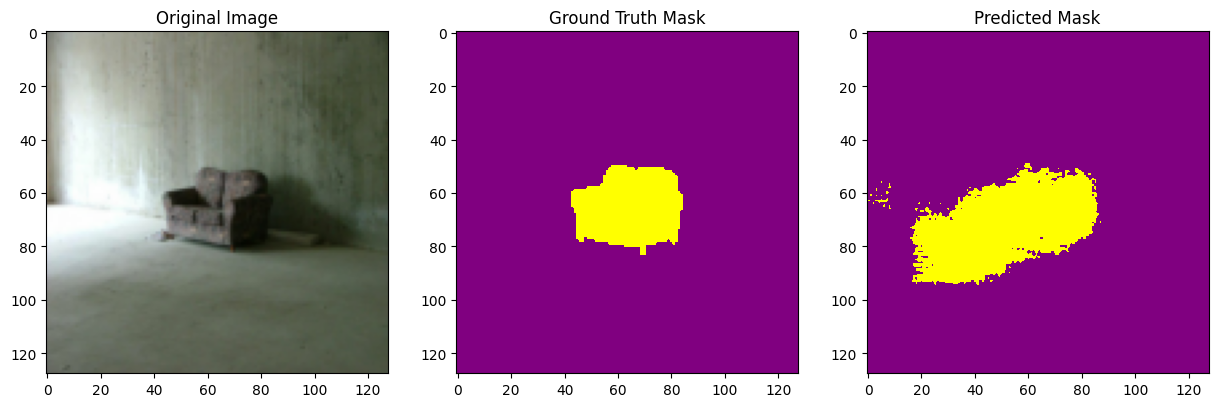

2/2 [==============================] - 0s 96ms/step


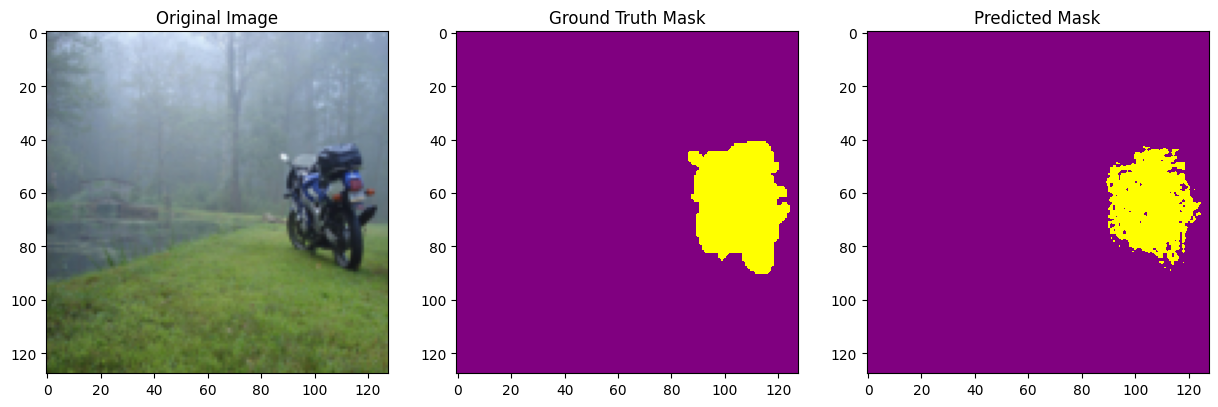

2/2 [==============================] - 0s 95ms/step


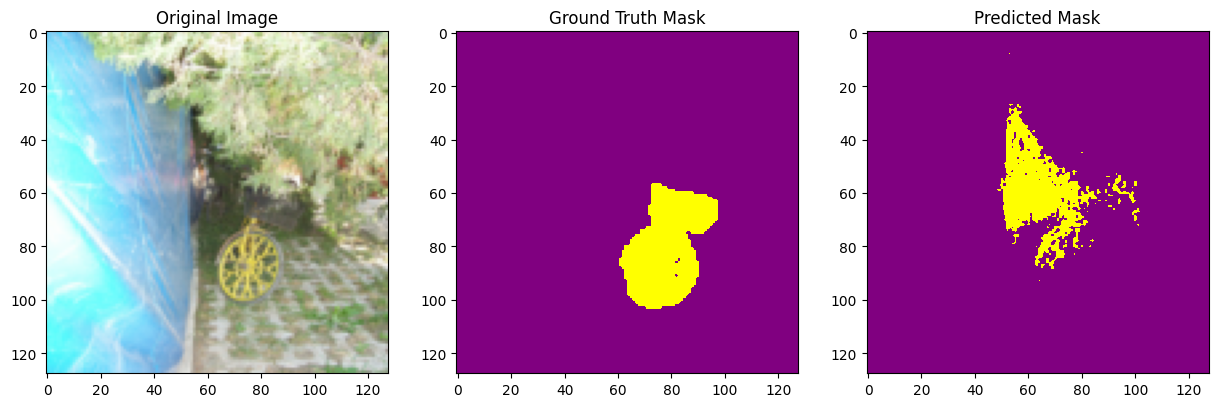

2/2 [==============================] - 0s 95ms/step


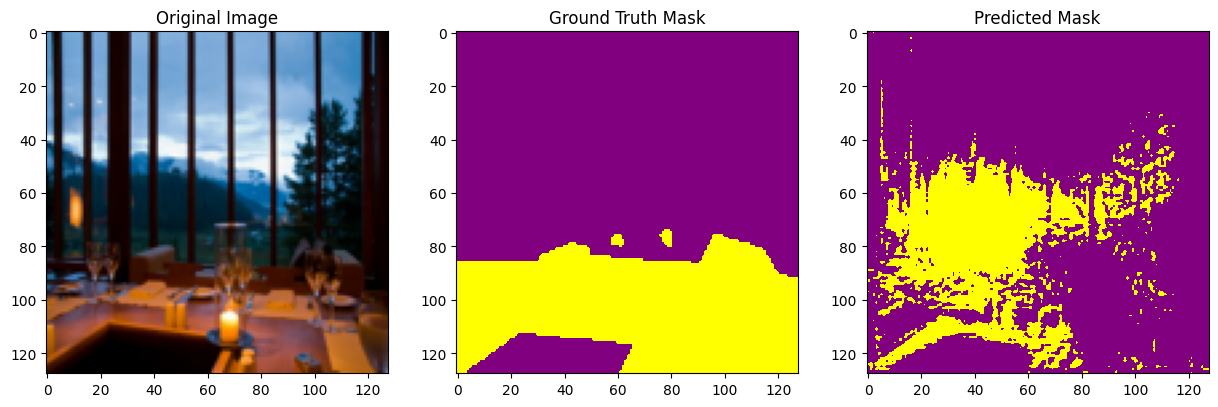

2/2 [==============================] - 0s 95ms/step


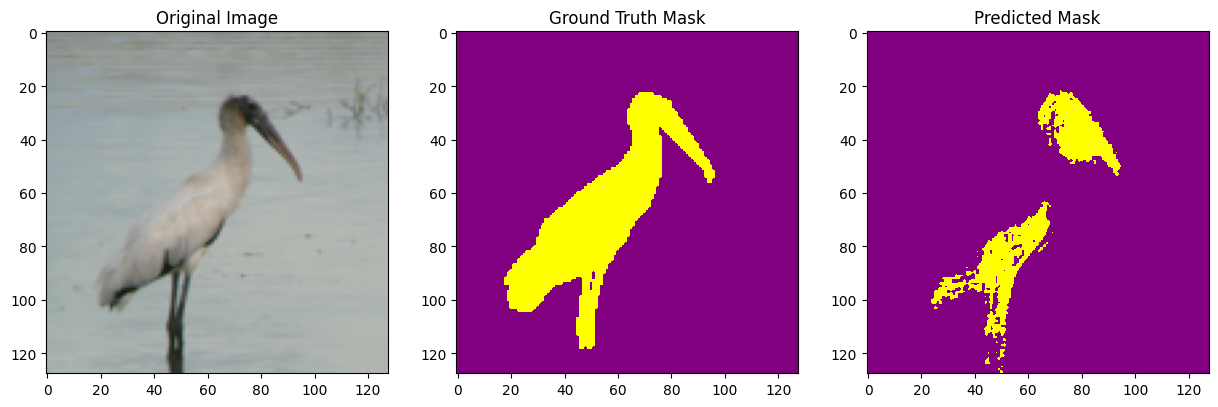

1/1 [==============================] - 0s 25ms/step


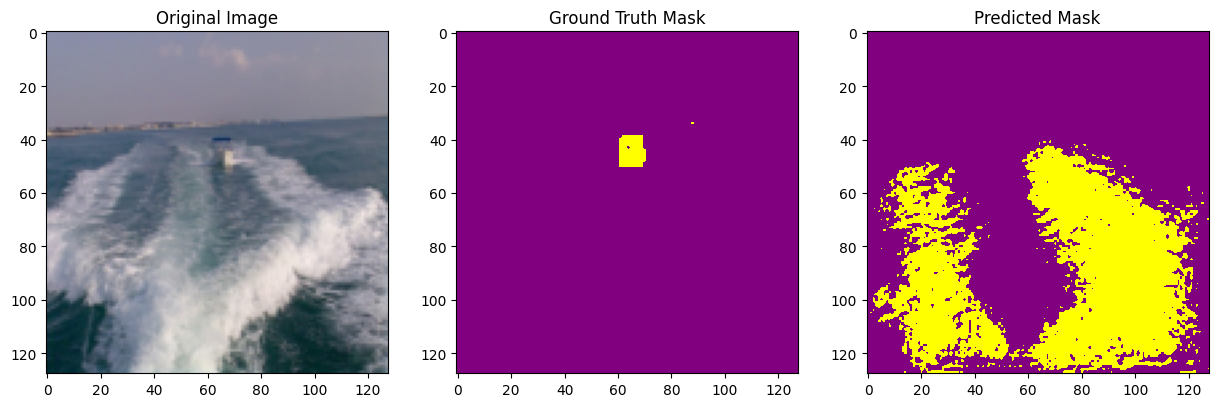

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define custom colormap
cmap_custom = plt.cm.colors.ListedColormap(['purple', 'yellow'])

# View predictions on some samples from the test dataset
num_predictions = 20
for i, sample in enumerate(test_ds.take(num_predictions)):
    image, mask = sample

    # Make predictions
    predictions = model.predict(image)

    # Plot original image, ground truth mask, and predicted mask
    plt.figure(figsize=(15, 5))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(image[0].numpy().astype("uint8"))
    plt.title('Original Image')

    # Ground truth mask
    plt.subplot(1, 3, 2)
    plt.imshow(mask[0].numpy(), cmap=cmap_custom)
    plt.title('Ground Truth Mask')

    # Predicted mask with custom colormap
    plt.subplot(1, 3, 3)
    plt.imshow(predictions[0][:, :, 0], cmap=cmap_custom)
    plt.title('Predicted Mask')

    plt.show()


Change optimizer

In [ ]:
gc.collect()

83210

In [ ]:
import matplotlib.pyplot as plt

# Assuming history contains metrics for each epoch
history_dict = history.history

# Define the metrics you want to plot
metrics_to_plot = ['loss', 'binary_accuracy', 'mean_iou', 'dice_score']

# Plot each metric
plt.figure(figsize=(15, 10))
for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(2, 3, i)
    metric_values = history_dict[metric]
    val_metric_values = history_dict['val_' + metric]  # Validation metrics
    epochs = range(1, len(metric_values) + 1)
    plt.plot(epochs, metric_values, 'bo', label='Training ' + metric)
    plt.plot(epochs, val_metric_values, 'b', label='Validation ' + metric)
    plt.title('Training and validation ' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()

plt.tight_layout()
plt.show()


# Training the model with   epochs

In [ ]:
# Fit the model
history = model.fit(train_ds,
                    epochs=30,
                    validation_data=val_ds )

In [ ]:
# Evaluate the model on the test dataset
test_result2 = model.evaluate(test_ds)
print(f'Test Loss: {test_result2[0]}')
print(f'Test Categorical Accuracy: {test_result2[1]}')
print(f'Test Precision: {test_result2[2]}')
print(f'Test Recall: {test_result2[3]}')
print(f'Test Mean IoU: {test_result2[4]}')
print(f'Test IoU: {test_result2[5]}')
print(f'Test Mean IoU (MeanIoU): {test_result2[6]}')
print(f'Test Dice Score: {test_result2[7]}')


12/12 [==============================] - 3s 209ms/step - loss: 0.5354 - categorical_accuracy: 0.0283 - precision_12: 0.5697 - recall_12: 0.3941 - mean_io_u_11: 0.3520 - iou: 0.3520 - mean_iou: 0.2675 - dice_score: 0.4220
Test Loss: 0.5354447960853577
Test Categorical Accuracy: 0.02832433208823204
Test Precision: 0.5697306990623474
Test Recall: 0.3940509259700775
Test Mean IoU: 0.3520463705062866
Test IoU: 0.3520463705062866
Test Mean IoU (MeanIoU): 0.26747947931289673
Test Dice Score: 0.42198649048805237


2/2 [==============================] - 7s 15ms/step


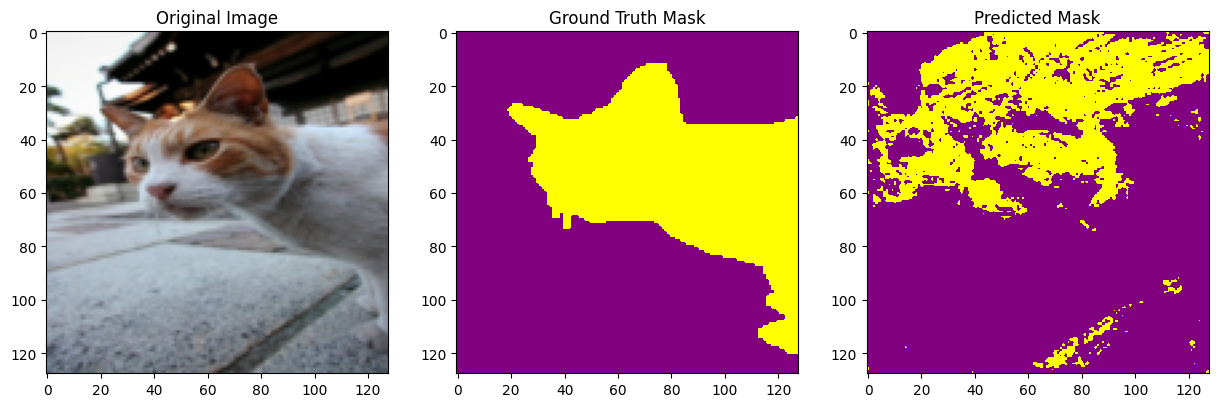

2/2 [==============================] - 0s 94ms/step


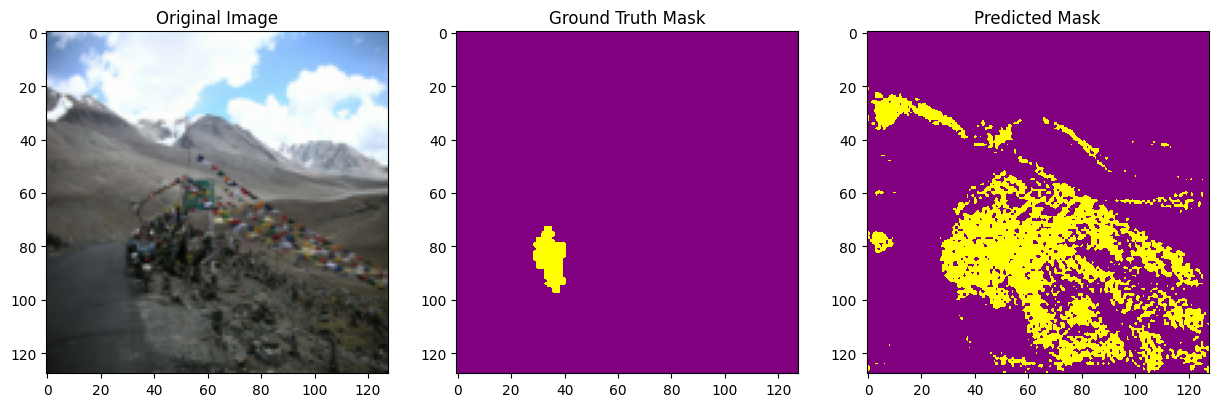

2/2 [==============================] - 0s 94ms/step


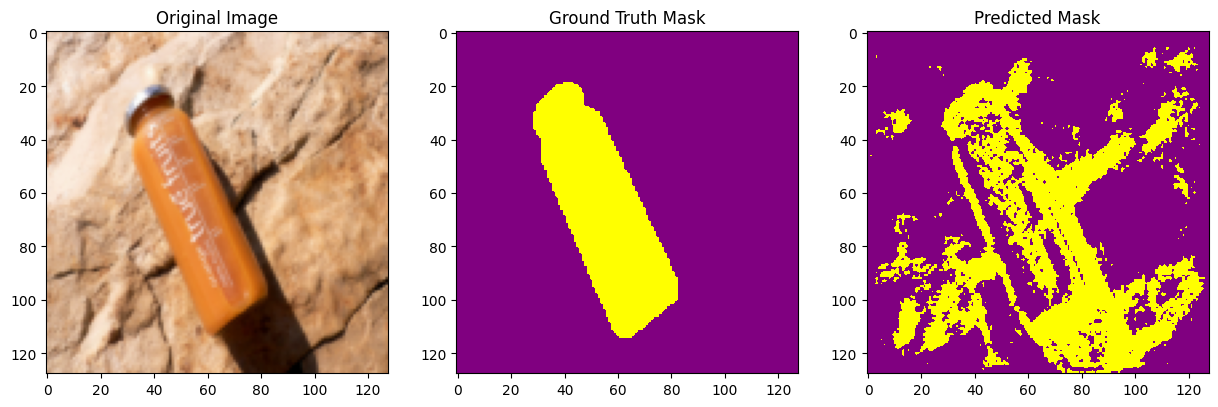

2/2 [==============================] - 0s 97ms/step


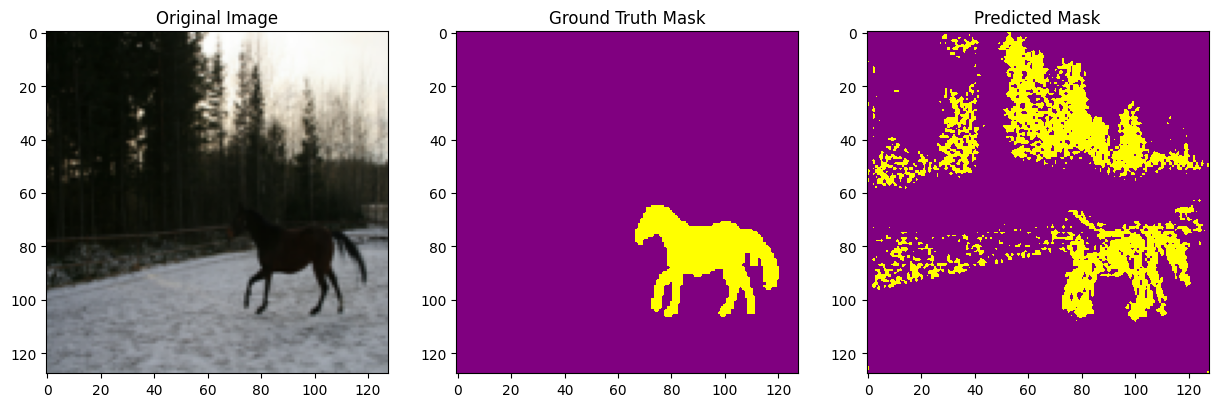

2/2 [==============================] - 0s 92ms/step


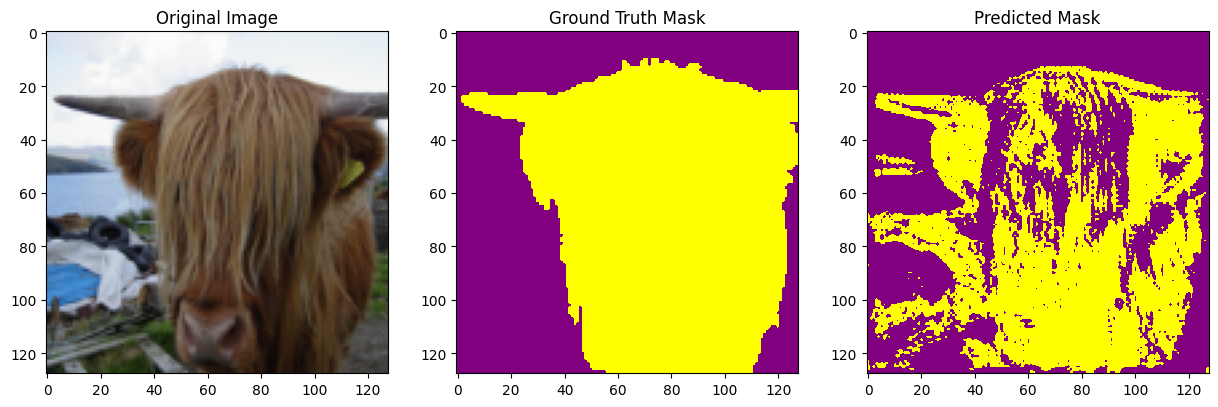

2/2 [==============================] - 0s 144ms/step


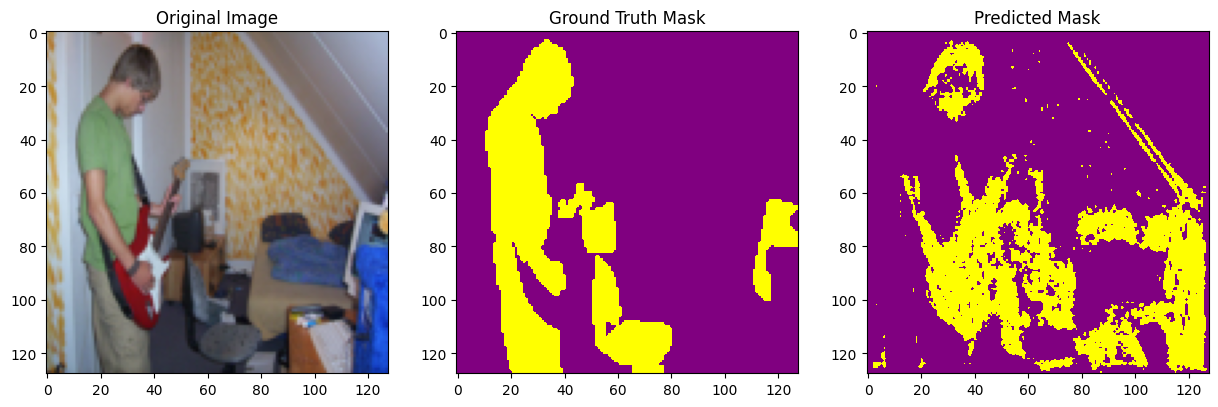

2/2 [==============================] - 0s 94ms/step


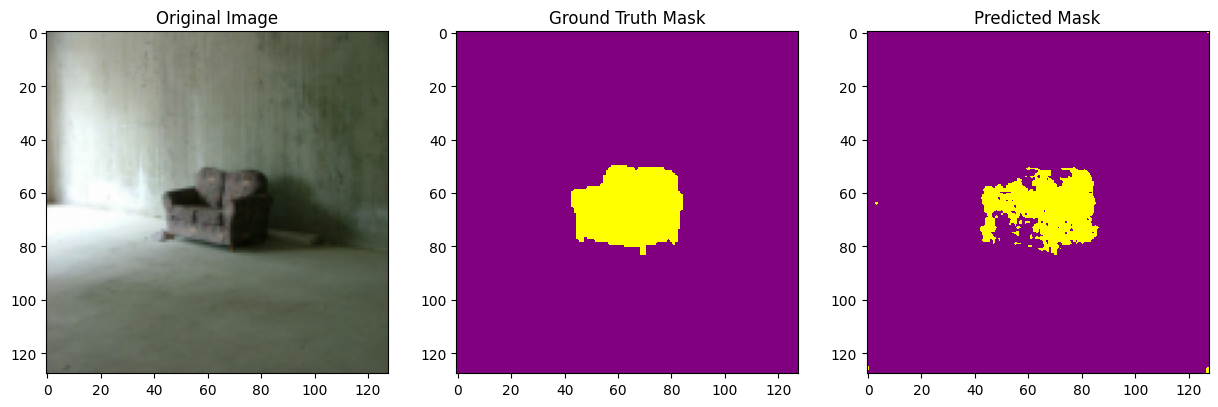

2/2 [==============================] - 0s 95ms/step


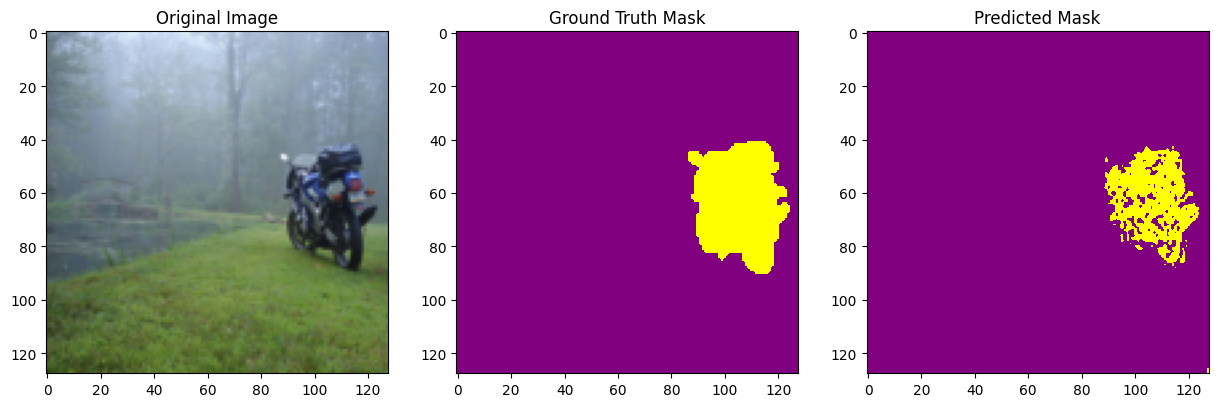

2/2 [==============================] - 0s 93ms/step


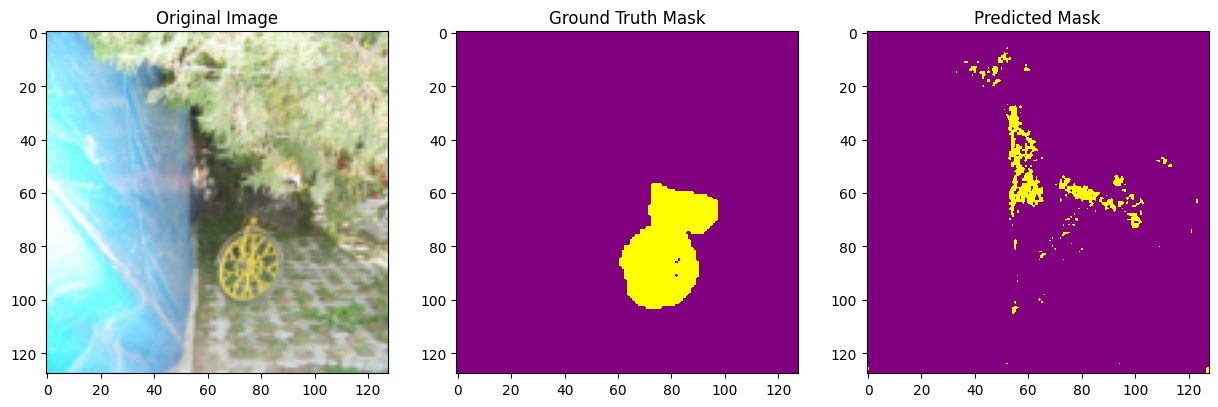

2/2 [==============================] - 0s 97ms/step


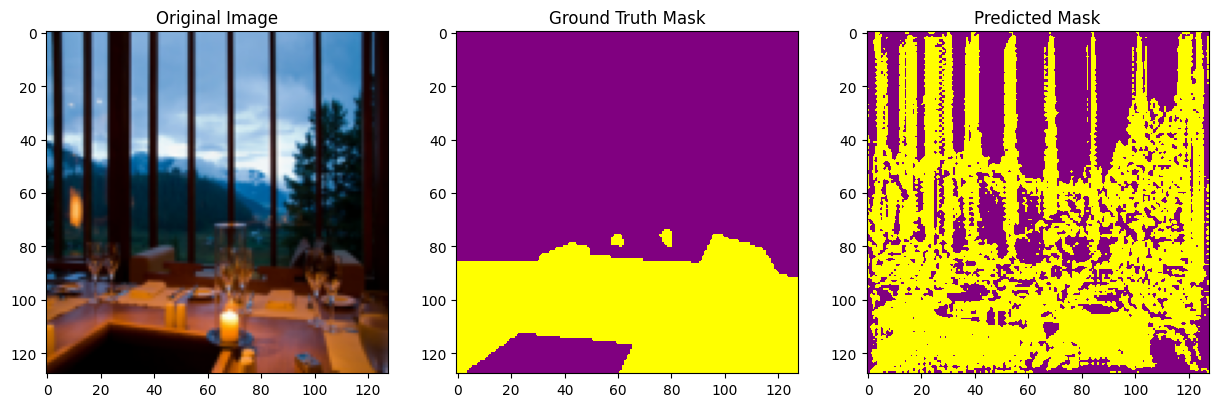

2/2 [==============================] - 0s 97ms/step


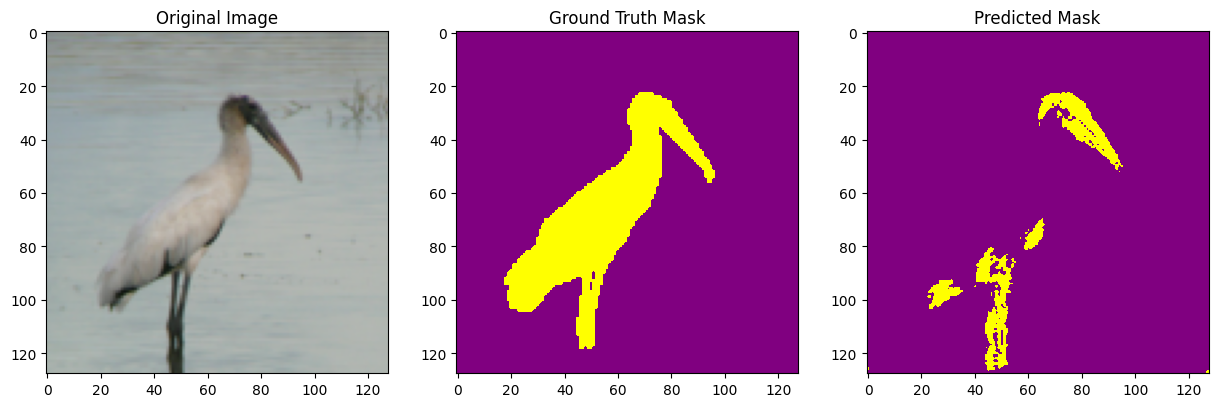

1/1 [==============================] - 0s 273ms/step


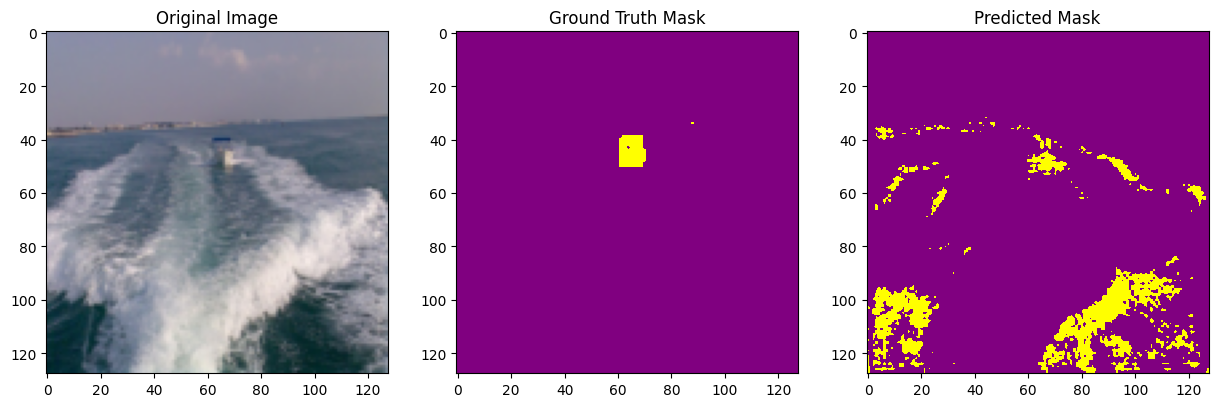

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define custom colormap
cmap_custom = plt.cm.colors.ListedColormap(['purple', 'yellow'])

# View predictions on some samples from the test dataset
num_predictions = 20
for i, sample in enumerate(test_ds.take(num_predictions)):
    image, mask = sample

    # Make predictions
    predictions = model.predict(image)

    # Plot original image, ground truth mask, and predicted mask
    plt.figure(figsize=(15, 5))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(image[0].numpy().astype("uint8"))
    plt.title('Original Image')

    # Ground truth mask
    plt.subplot(1, 3, 2)
    plt.imshow(mask[0].numpy(), cmap=cmap_custom)
    plt.title('Ground Truth Mask')

    # Predicted mask with custom colormap
    plt.subplot(1, 3, 3)
    plt.imshow(predictions[0][:, :, 0], cmap=cmap_custom)
    plt.title('Predicted Mask')

    plt.show()


#continuation


 # Replacing Conv2DTranspose with UpSampling2D and Standard Convolution

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Define U-Net model architecture for binary segmentation
def create_binary_unet(input_shape=(128,128,3)):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottom
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder
    up6 = layers.UpSampling2D(size=(2, 2))(conv5)
    up6 = layers.Conv2D(512, 2, activation='relu', padding='same')(up6)
    up6 = layers.concatenate([up6, conv4], axis=3)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = layers.UpSampling2D(size=(2, 2))(conv6)
    up7 = layers.Conv2D(256, 2, activation='relu', padding='same')(up7)
    up7 = layers.concatenate([up7, conv3], axis=3)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = layers.UpSampling2D(size=(2, 2))(conv7)
    up8 = layers.Conv2D(128, 2, activation='relu', padding='same')(up8)
    up8 = layers.concatenate([up8, conv2], axis=3)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = layers.UpSampling2D(size=(2, 2))(conv8)
    up9 = layers.Conv2D(64, 2, activation='relu', padding='same')(up9)
    up9 = layers.concatenate([up9, conv1], axis=3)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)

    # Output layer
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv9)  # Sigmoid activation for binary classification

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Assuming _IMAGE_SHAPE is defined elsewhere in your code
_IMAGE_SHAPE = (128, 128)

model = create_binary_unet(input_shape=(_IMAGE_SHAPE[0], _IMAGE_SHAPE[1], 3))


In [ ]:
# Compile the model with custom mean IoU metric and Dice score
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=losses.BinaryCrossentropy(),
              metrics=[metrics.BinaryAccuracy(),
                       metrics.Precision(),
                       metrics.Recall(),
                       metrics.MeanIoU(num_classes=_NUM_CLASSES),
                       metrics.MeanIoU(num_classes=_NUM_CLASSES, name='iou'),
                       mean_iou,
                       dice_score])


In [ ]:
# Fit the model
history = model.fit(train_ds,
                    epochs=30,
                    validation_data=val_ds )

Epoch 1/30
23/23 [==============================] - 48s 1s/step - loss: 0.7486 - binary_accuracy: 0.6671 - precision_14: 0.4508 - recall_14: 0.3568 - mean_io_u_13: 0.3456 - iou: 0.3456 - mean_iou: 0.2380 - dice_score: 0.3820 - val_loss: 0.6095 - val_binary_accuracy: 0.6861 - val_precision_14: 0.4990 - val_recall_14: 0.4055 - val_mean_io_u_13: 0.3433 - val_iou: 0.3433 - val_mean_iou: 0.2669 - val_dice_score: 0.4211
Epoch 2/30
23/23 [==============================] - 23s 1s/step - loss: 0.5641 - binary_accuracy: 0.7185 - precision_14: 0.5552 - recall_14: 0.4450 - mean_io_u_13: 0.3456 - iou: 0.3456 - mean_iou: 0.2865 - dice_score: 0.4447 - val_loss: 0.5707 - val_binary_accuracy: 0.7149 - val_precision_14: 0.5418 - val_recall_14: 0.5856 - val_mean_io_u_13: 0.3433 - val_iou: 0.3433 - val_mean_iou: 0.3155 - val_dice_score: 0.4794
Epoch 3/30
23/23 [==============================] - 24s 1s/step - loss: 0.5238 - binary_accuracy: 0.7454 - precision_14: 0.6071 - recall_14: 0.4978 - mean_io_u_13: 

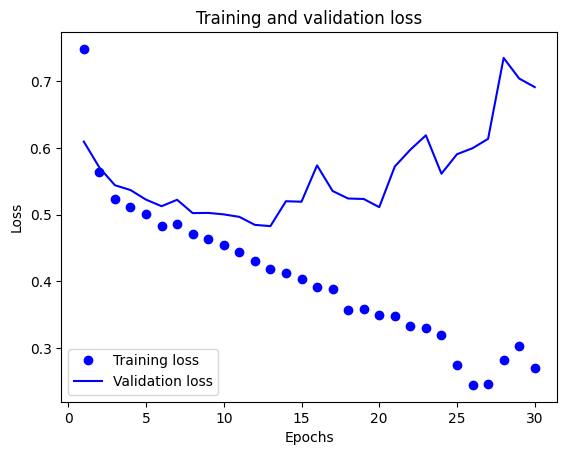

In [ ]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()



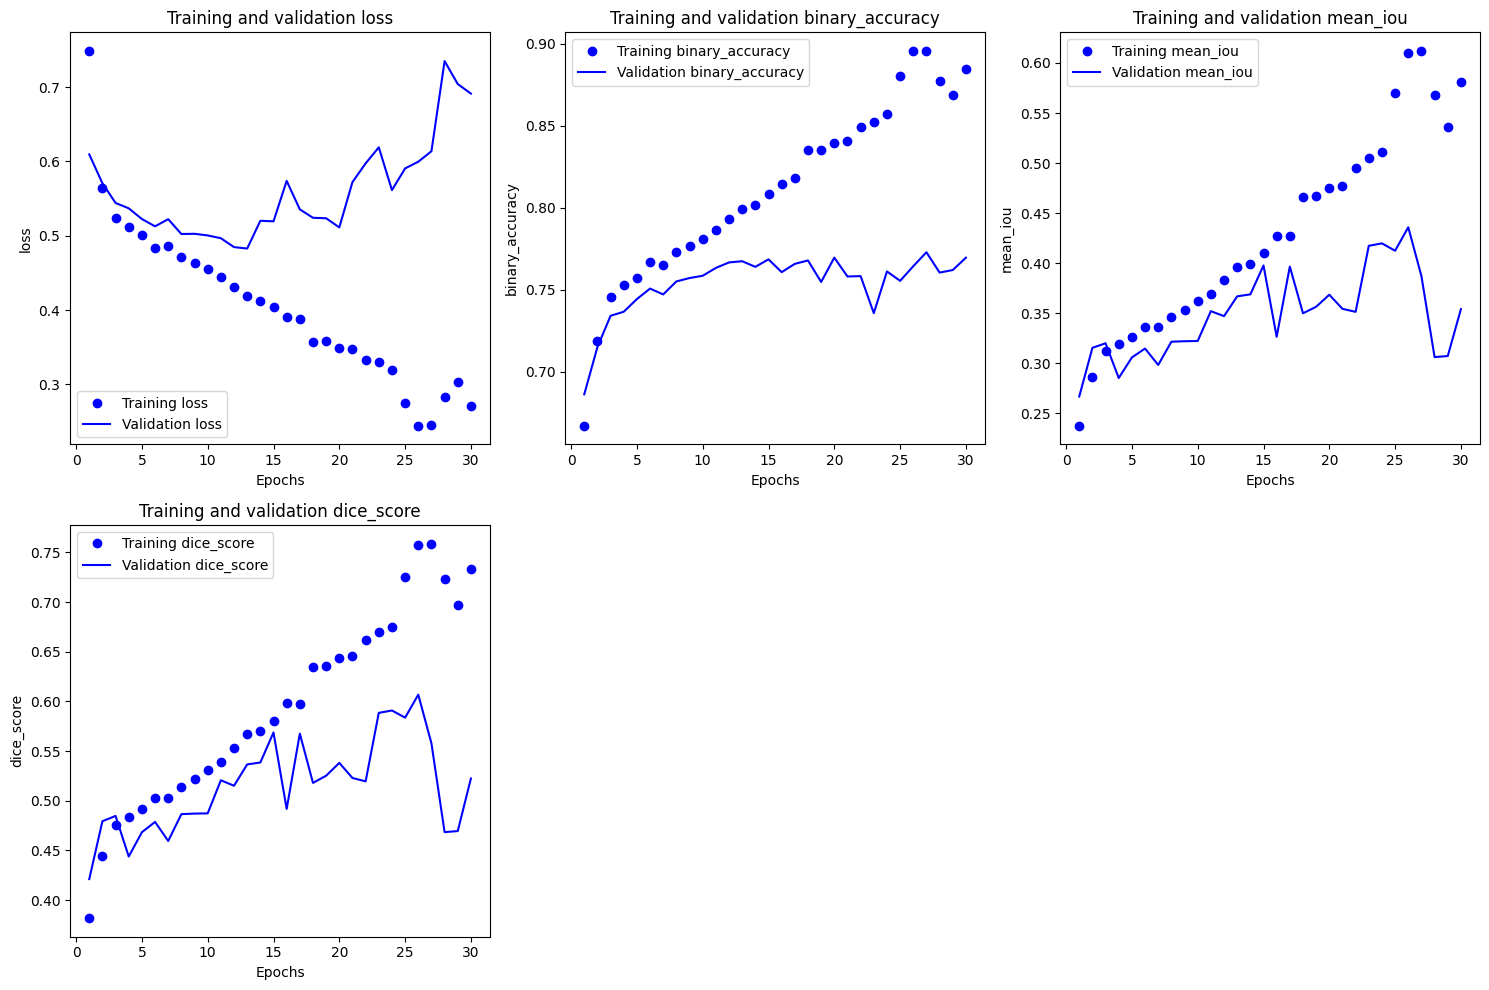

In [ ]:
import matplotlib.pyplot as plt

# Assuming history contains metrics for each epoch
history_dict = history.history

# Define the metrics you want to plot
metrics_to_plot = ['loss', 'binary_accuracy', 'mean_iou', 'dice_score']

# Plot each metric
plt.figure(figsize=(15, 10))
for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(2, 3, i)
    metric_values = history_dict[metric]
    val_metric_values = history_dict['val_' + metric]  # Validation metrics
    epochs = range(1, len(metric_values) + 1)
    plt.plot(epochs, metric_values, 'bo', label='Training ' + metric)
    plt.plot(epochs, val_metric_values, 'b', label='Validation ' + metric)
    plt.title('Training and validation ' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()

plt.tight_layout()
plt.show()


# Training the final model using 15 epochs

In [ ]:
# Fit the model
history = model.fit(train_ds,
                    epochs=15,
                    validation_data=val_ds )

Epoch 1/15
23/23 [==============================] - 23s 1s/step - loss: 0.2163 - binary_accuracy: 0.9095 - precision_14: 0.8563 - recall_14: 0.8496 - mean_io_u_13: 0.3458 - iou: 0.3458 - mean_iou: 0.6513 - dice_score: 0.7886 - val_loss: 0.8133 - val_binary_accuracy: 0.7537 - val_precision_14: 0.7315 - val_recall_14: 0.3384 - val_mean_io_u_13: 0.3433 - val_iou: 0.3433 - val_mean_iou: 0.2979 - val_dice_score: 0.4586
Epoch 2/15
23/23 [==============================] - 25s 1s/step - loss: 0.2235 - binary_accuracy: 0.9063 - precision_14: 0.8538 - recall_14: 0.8404 - mean_io_u_13: 0.3459 - iou: 0.3459 - mean_iou: 0.6419 - dice_score: 0.7816 - val_loss: 0.8499 - val_binary_accuracy: 0.7488 - val_precision_14: 0.7091 - val_recall_14: 0.3366 - val_mean_io_u_13: 0.3433 - val_iou: 0.3433 - val_mean_iou: 0.2931 - val_dice_score: 0.4525
Epoch 3/15
23/23 [==============================] - 26s 1s/step - loss: 0.2304 - binary_accuracy: 0.9038 - precision_14: 0.8517 - recall_14: 0.8338 - mean_io_u_13: 

In [ ]:
# Evaluate the model on the test dataset
test_result2 = model.evaluate(test_ds)
print(f'Test Loss: {test_result2[0]}')
print(f'Test Binary Accuracy: {test_result2[1]}')
print(f'Test Precision: {test_result2[2]}')
print(f'Test Recall: {test_result2[3]}')
print(f'Test Mean IoU: {test_result2[4]}')
print(f'Test IoU: {test_result2[5]}')
print(f'Test Mean IoU (MeanIoU): {test_result2[6]}')
print(f'Test Dice Score: {test_result2[7]}')


12/12 [==============================] - 3s 259ms/step - loss: 0.6298 - binary_accuracy: 0.7919 - precision_14: 0.7355 - recall_14: 0.4636 - mean_io_u_13: 0.3520 - iou: 0.3520 - mean_iou: 0.3672 - dice_score: 0.5362
Test Loss: 0.6298406720161438
Test Binary Accuracy: 0.7919378280639648
Test Precision: 0.7354546189308167
Test Recall: 0.46363958716392517
Test Mean IoU: 0.3520463705062866
Test IoU: 0.3520463705062866
Test Mean IoU (MeanIoU): 0.3672045171260834
Test Dice Score: 0.536162793636322


2/2 [==============================] - 2s 31ms/step


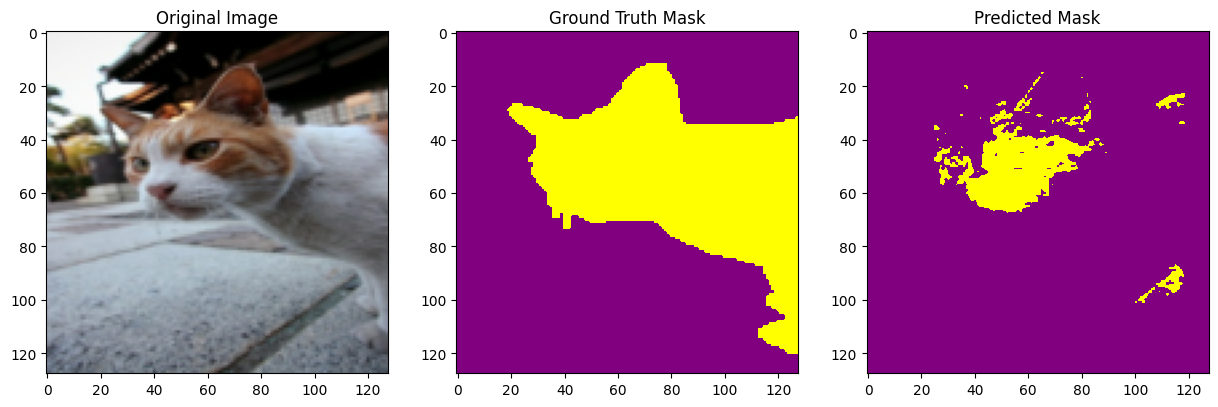

2/2 [==============================] - 0s 181ms/step


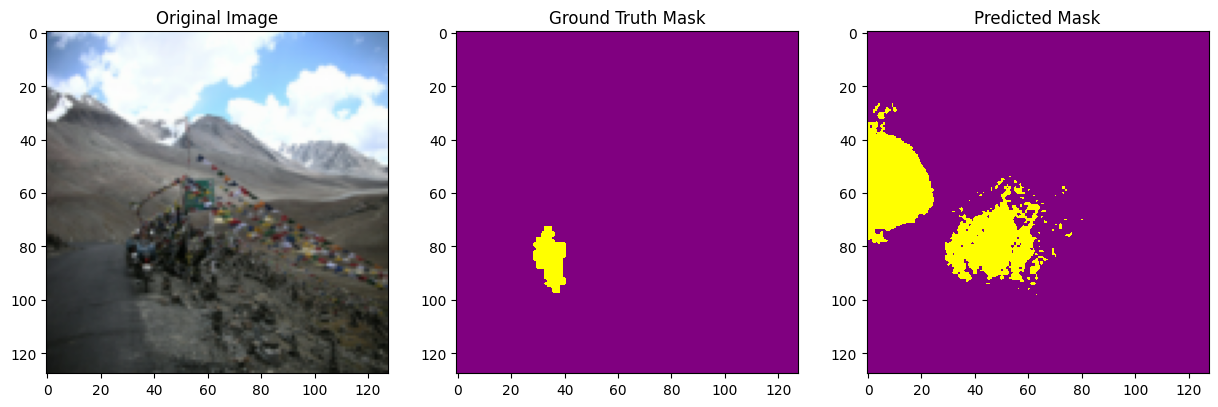

2/2 [==============================] - 0s 128ms/step


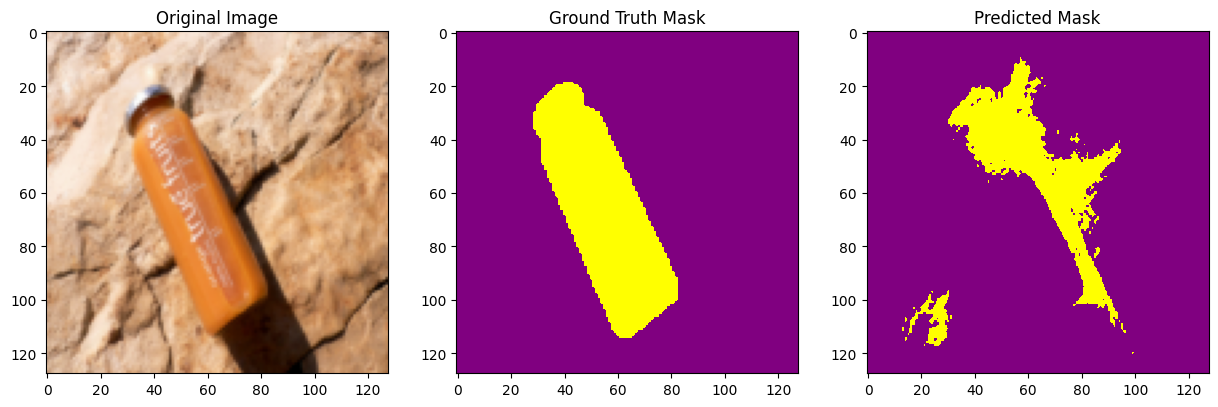

2/2 [==============================] - 0s 121ms/step


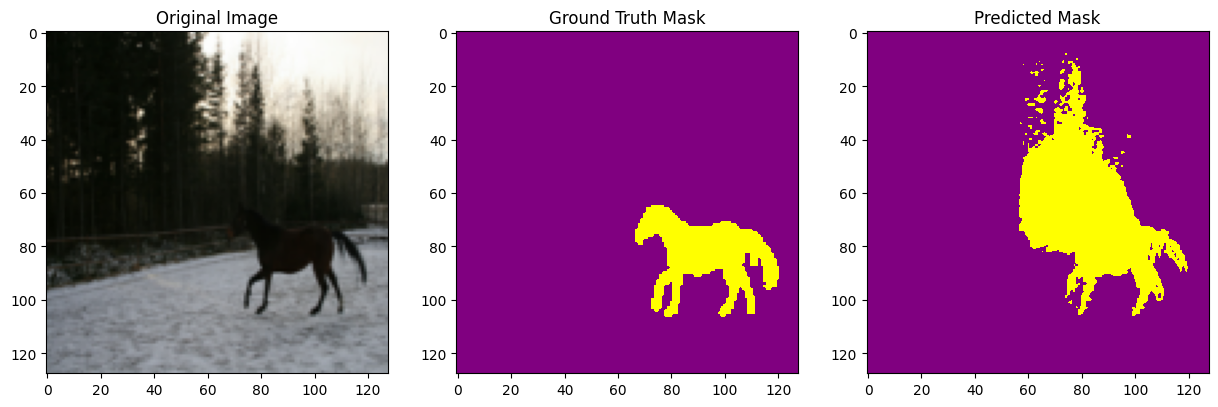

2/2 [==============================] - 0s 121ms/step


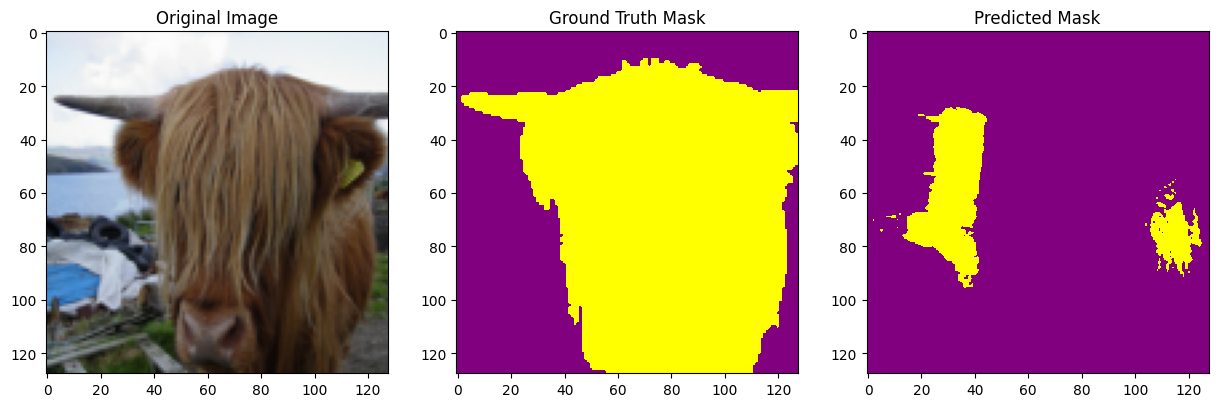

2/2 [==============================] - 0s 126ms/step


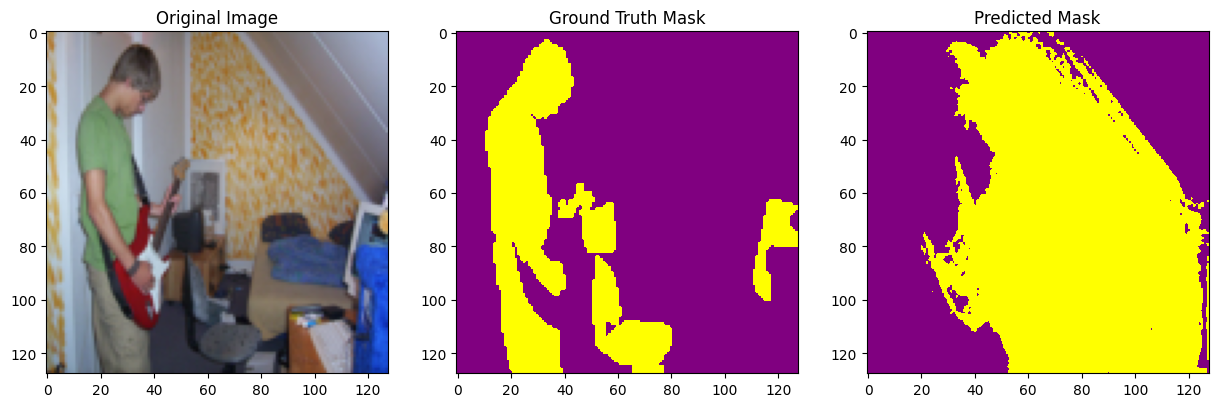

2/2 [==============================] - 0s 121ms/step


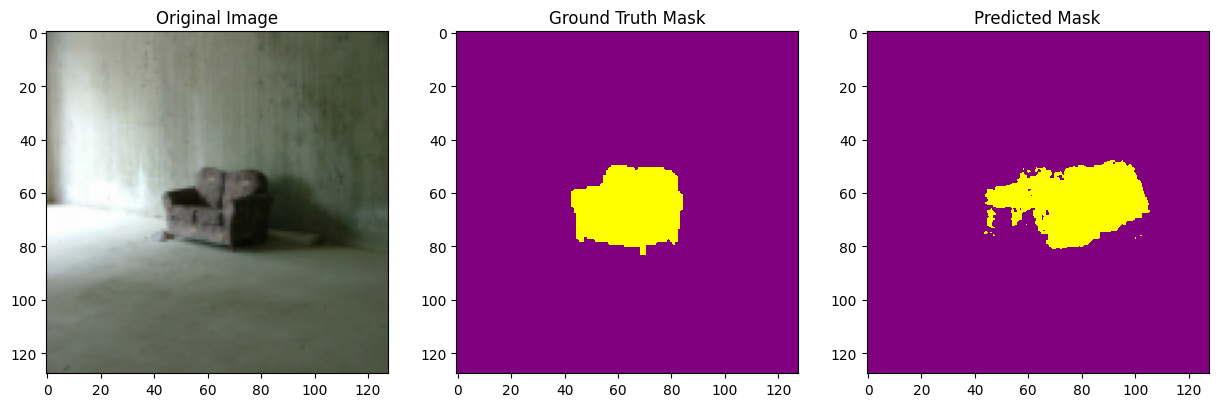

2/2 [==============================] - 0s 123ms/step


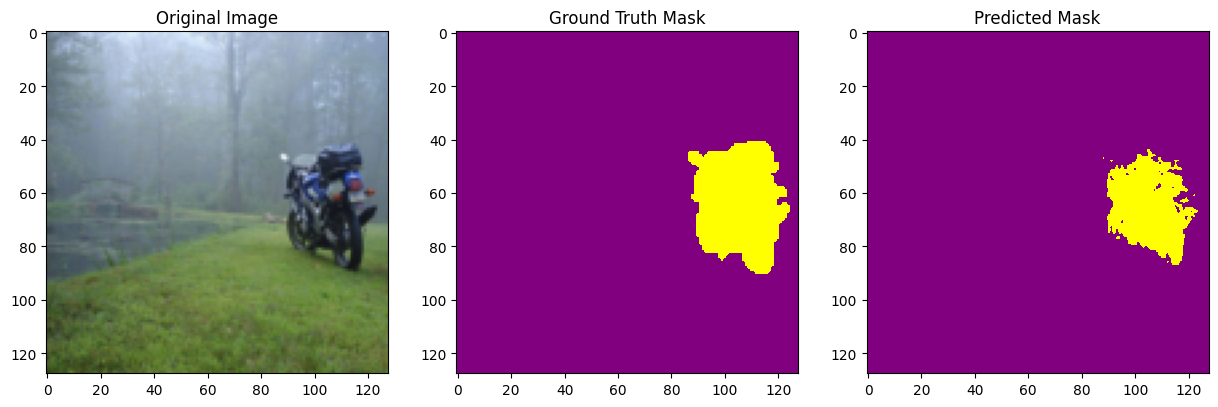

2/2 [==============================] - 0s 121ms/step


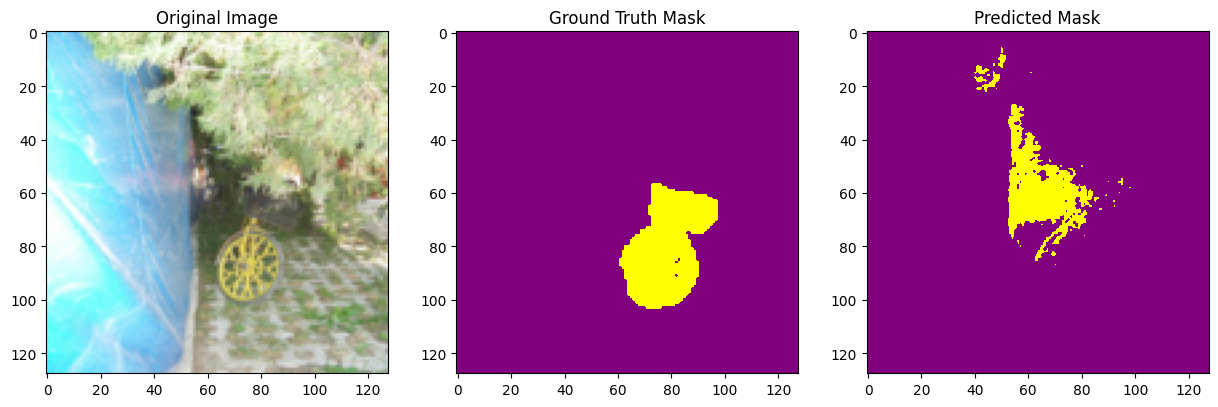

2/2 [==============================] - 0s 123ms/step


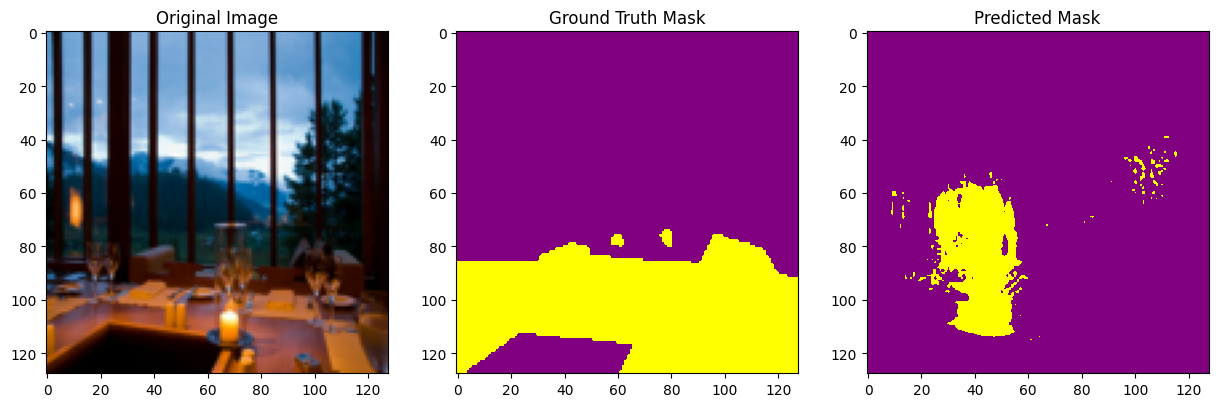

2/2 [==============================] - 0s 122ms/step


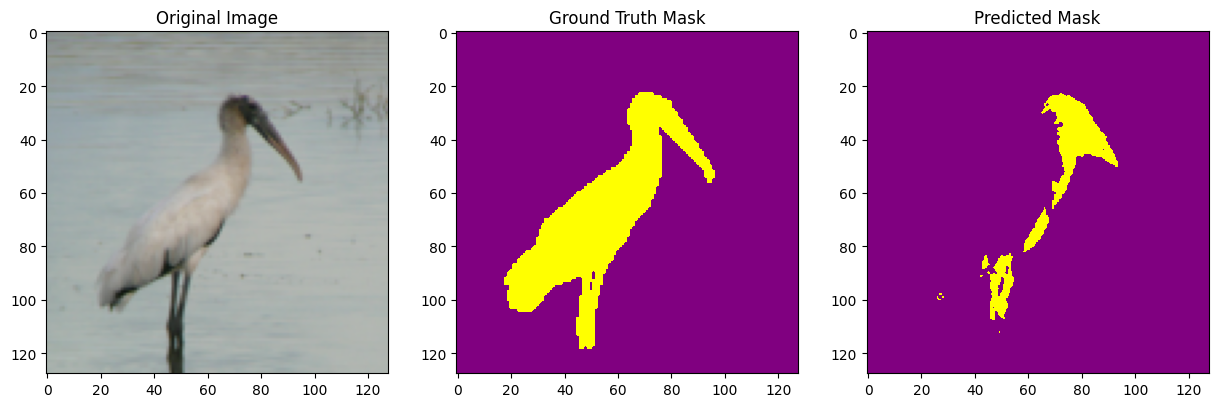

1/1 [==============================] - 0s 233ms/step


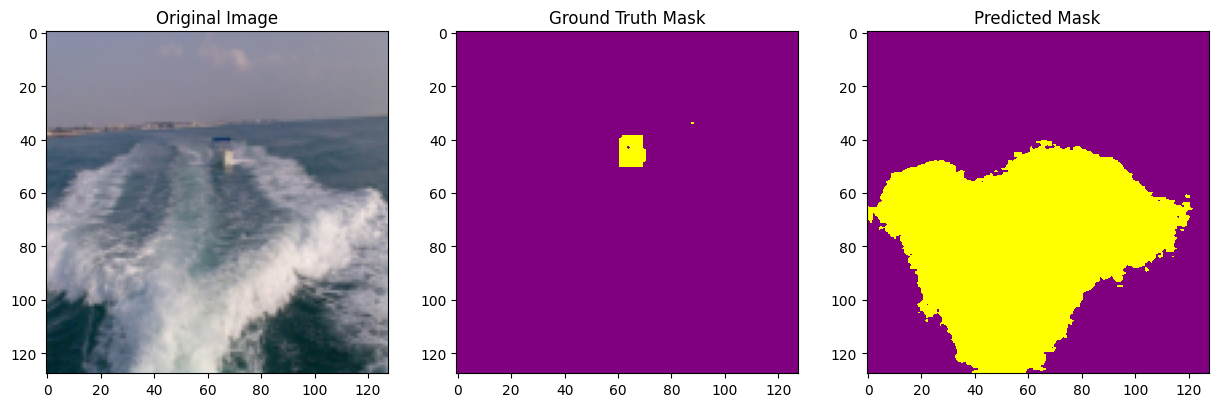

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define custom colormap
cmap_custom = plt.cm.colors.ListedColormap(['purple', 'yellow'])

# View predictions on some samples from the test dataset
num_predictions = 20
for i, sample in enumerate(test_ds.take(num_predictions)):
    image, mask = sample

    # Make predictions
    predictions = model.predict(image)

    # Plot original image, ground truth mask, and predicted mask
    plt.figure(figsize=(15, 5))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(image[0].numpy().astype("uint8"))
    plt.title('Original Image')

    # Ground truth mask
    plt.subplot(1, 3, 2)
    plt.imshow(mask[0].numpy(), cmap=cmap_custom)
    plt.title('Ground Truth Mask')

    # Predicted mask with custom colormap
    plt.subplot(1, 3, 3)
    plt.imshow(predictions[0][:, :, 0], cmap=cmap_custom)
    plt.title('Predicted Mask')

    plt.show()
